In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from tqdm import tqdm
import sys
import yaml
from gc import collect

from train import load_data
import models as M

2023-11-19 02:40:26.002260: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 02:40:26.082480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 02:40:27.498862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend
tf INFO messages are suppressed.
sklearn version: 1.3.1


In [2]:
HESSIANS_PATH = '/smallwork/alexander.huang/vanilla_hessians/outbound/10000/49595431/block_vanilla_interactions.npy'
GRADIENTS_PATH = '/smallwork/alexander.huang/saliency_maps/outbound/all/49595429/block_saliency_maps.npy'

In [3]:
def imshow_zero_center(hessian, **kwargs):
    lim = tf.reduce_max(abs(hessian))
    plt.imshow(hessian, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
    plt.colorbar()

In [4]:
mean_interactions=np.load('/smallwork/alexander.huang/vanilla_hessians/outbound/100/block_mean_vanilla_interactions.npy')
'''
# remove interactions < 1e-4
threshold = 1e-2
indices = np.where(np.abs(mean_interactions[0]) < threshold)
filter_interactions = np.delete(mean_interactions, indices, axis=0)
filter_interactions = np.delete(filter_interactions, indices, axis=1)

imshow_zero_center(filter_interactions)
'''
imshow_zero_center(mean_interactions)

FileNotFoundError: [Errno 2] No such file or directory: '/smallwork/alexander.huang/vanilla_hessians/outbound/100/block_mean_vanilla_interactions.npy'

In [6]:
DATA_DIR = '/data/alexander.huang/data/0903_data/test_drop/outbound_x_test.parq'

df = pd.read_parquet(DATA_DIR)
feature_names = df.columns.tolist()

In [7]:
ipfeatureindex = []
ipfeaturenames = []
for ele in feature_names:
    if ele.startswith('inside_ip_dst_'):
        #print(ele)
        ipfeaturenames.append(ele)
        ipfeatureindex.append(feature_names.index(ele))
print(len(ipfeaturenames))
print(len(ipfeatureindex))

162
162


In [8]:
portfeatureindex = []
portfeaturenames = []
for ele in feature_names:
    if ele.startswith('inside_port_dst_'):
        #print(ele)
        portfeaturenames.append(ele)
        portfeatureindex.append(feature_names.index(ele))
print(len(portfeaturenames))
print(len(portfeatureindex))

42
42


In [9]:
iptoport = np.zeros(shape=(len(portfeatureindex),len(ipfeatureindex)))
a = 0
for i in portfeatureindex:
    b=0
    for j in ipfeatureindex:
        iptoport[a,b] = mean_interactions[i,j]
        b+=1
    a+=1
        
iptoport.shape

print(iptoport.shape)
print(mean_interactions)

NameError: name 'mean_interactions' is not defined

In [10]:
iptoport.shape
idx = np.argwhere(np.all(iptoport[..., :] < 1e-2, axis=0))
for index in idx.flatten():
    ipfeaturenames[index]=''
a2 = np.delete(iptoport, idx, axis=1)

iptoport.shape
idx = np.argwhere(np.all(iptoport[:, ...] < 1e-2, axis=1))
for index in idx.flatten():
    portfeaturenames[index]=''
a2 = np.delete(a2, idx, axis=0)

ipfeaturenames=[item for index,item in enumerate(ipfeaturenames) if item !='']
portfeaturenames=[item for index,item in enumerate(portfeaturenames) if item !='']

2023-11-19 01:53:35.751298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46497 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1a:00.0, compute capability: 8.9
/tmp/ipykernel_61077/270722755.py:9: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')
/tmp/ipykernel_61077/270722755.py:9: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')


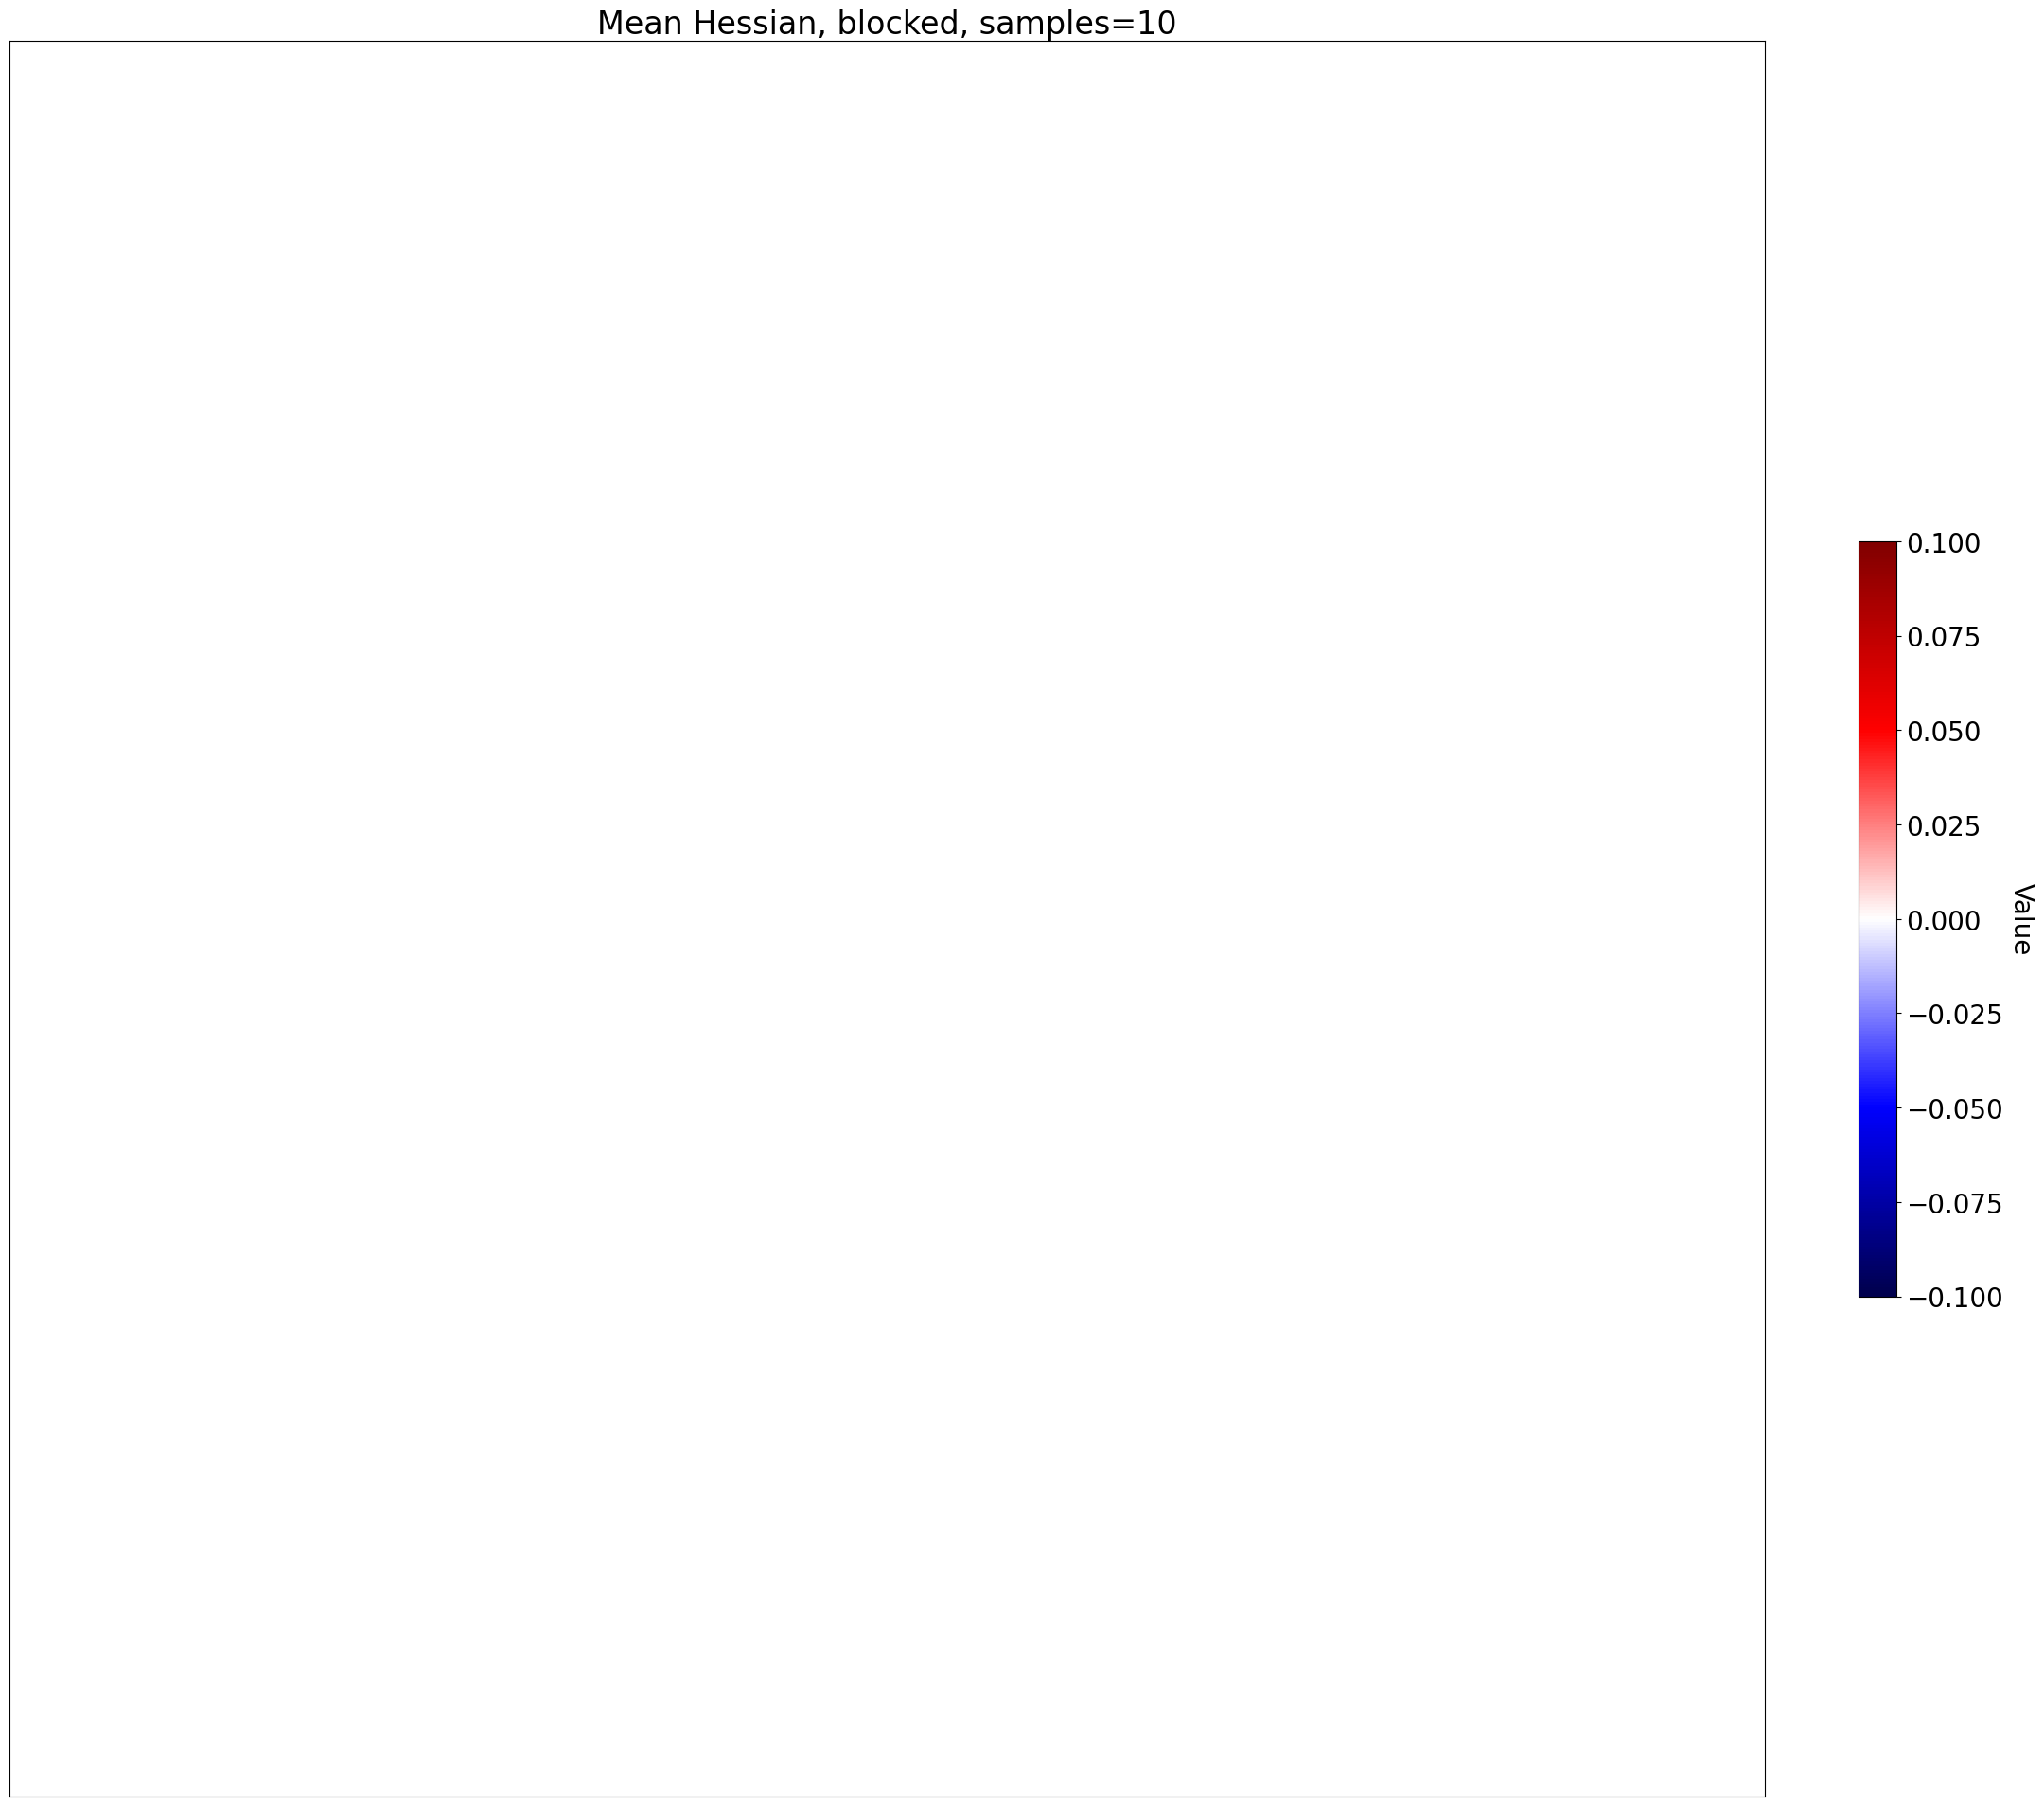

In [11]:
plot = a2
x_names = ipfeaturenames
y_names = portfeaturenames

fig, ax = plt.subplots(figsize=(22, 22))
matplotlib.rcParams.update({'font.size': 20})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.02)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="b")
'''

ax.set_title("Mean Hessian, blocked, samples=10")
fig.tight_layout()
plt.savefig('hessian.png', dpi=300)

In [9]:
top10 = np.dstack(np.unravel_index(np.argpartition(mean_interactions.ravel(),20)[:20], mean_interactions.shape)).squeeze()

In [10]:
top10

array([[  0, 230],
       [207,   0],
       [214, 214],
       [  0, 207],
       [230,   0],
       [  0,   0],
       [231, 214],
       [214, 231],
       [231, 231],
       [240, 230],
       [  6, 214],
       [230, 240],
       [  0, 183],
       [  1,   1],
       [183,   0],
       [214,   6],
       [223,  10],
       [ 10, 223],
       [183, 183],
       [  6, 231]])

In [11]:
top10=np.unique(np.sort(top10), axis=0)

In [12]:
for i,j in top10:
    print(feature_names[i],',',feature_names[j], ':', mean_interactions[i][j])

inside_ip_len , inside_ip_len : -0.7978982
inside_ip_len , inside_port_src_53 : -0.36689824
inside_ip_len , inside_port_dst_HIGH : -0.44906655
inside_ip_len , inside_port_dst_53 : -0.49655774
inside_ip_dst_LAT , inside_ip_dst_LAT : -0.32861027
inside_ip_protocol_1 , inside_port_dst_143 : -0.31845996
inside_ip_protocol_1 , inside_port_dst_585 : -0.30133042
inside_ip_protocol_6 , inside_port_dst_443 : -0.31587216
inside_port_src_53 , inside_port_src_53 : -0.31660956
inside_port_dst_143 , inside_port_dst_143 : -0.40437886
inside_port_dst_143 , inside_port_dst_585 : -0.38345584
inside_port_dst_53 , inside_port_dst_80 : -0.34477955
inside_port_dst_585 , inside_port_dst_585 : -0.3634404


# Comparing Gradients with Hessians

In [12]:
HESSIANS_PATH = '/smallwork/alexander.huang/vanilla_hessians/outbound/10000/49595431/block_vanilla_interactions.npy'
GRADIENTS_PATH = '/smallwork/alexander.huang/saliency_maps/outbound/all/49595429/block_saliency_maps.npy'
DATA_DIR = '/data/alexander.huang/data/0903_data/test_drop/outbound_x_test.parq'

df = pd.read_parquet(DATA_DIR)
feature_names = df.columns.tolist()

In [13]:
blocked_hessians = np.load(HESSIANS_PATH)
blocked_hessians.shape

(10000, 246, 246)

In [14]:
blocked_gradients = np.load(GRADIENTS_PATH)
blocked_gradients.shape

(107109, 246)

In [15]:
avg_gradients = np.mean(blocked_gradients, axis=0)
print(avg_gradients.shape)


(246,)


In [16]:
grad_sign = np.sign(avg_gradients)
print(grad_sign)

[-1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.
  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.
  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.
 -1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1.
 -1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1.]


In [17]:
avg_hessian = np.mean(blocked_hessians, axis=0)
std_hessian = np.std(blocked_hessians, axis=0)
print(avg_hessian.shape)
print(avg_hessian)

(246, 246)
[[-7.8588587e-01  6.6619384e-01 -7.0551127e-02 ... -4.9464237e-02
  -3.0175727e-03  2.6688728e-04]
 [ 6.6623837e-01 -3.0699709e-01  5.9594661e-02 ...  7.4162982e-02
   3.3130383e-03 -1.3038678e-04]
 [-7.0544943e-02  5.9588887e-02 -2.3292121e-02 ... -4.0743631e-04
  -1.1232141e-04  2.0735415e-05]
 ...
 [-4.9465675e-02  7.4161075e-02 -4.0914904e-04 ... -2.3358788e-02
  -1.0713693e-03  7.6737037e-05]
 [-3.0177282e-03  3.3129337e-03 -1.1241764e-04 ... -1.0713736e-03
  -4.8673050e-05  3.2256230e-06]
 [ 2.6689094e-04 -1.3037882e-04  2.0739702e-05 ...  7.6735596e-05
   3.2255773e-06 -1.4046854e-07]]


In [20]:
interaction_matrix = np.zeros((246,246))
num_features = len(avg_gradients)

# feature by row, so lock each row
for i in range(num_features):
    for j in range(num_features):
        interaction_matrix[i,j] = grad_sign[i] *  avg_hessian[i,j]

In [21]:
print(interaction_matrix)

[[ 7.85885870e-01 -6.66193843e-01  7.05511272e-02 ...  4.94642369e-02
   3.01757269e-03 -2.66887277e-04]
 [ 6.66238368e-01 -3.06997091e-01  5.95946610e-02 ...  7.41629824e-02
   3.31303827e-03 -1.30386776e-04]
 [-7.05449432e-02  5.95888868e-02 -2.32921205e-02 ... -4.07436310e-04
  -1.12321410e-04  2.07354151e-05]
 ...
 [ 4.94656749e-02 -7.41610751e-02  4.09149041e-04 ...  2.33587883e-02
   1.07136928e-03 -7.67370366e-05]
 [ 3.01772822e-03 -3.31293372e-03  1.12417642e-04 ...  1.07137358e-03
   4.86730496e-05 -3.22562300e-06]
 [ 2.66890944e-04 -1.30378816e-04  2.07397024e-05 ...  7.67355959e-05
   3.22557730e-06 -1.40468543e-07]]


In [22]:
ipfeatureindex = []
ipfeaturenames = []
for ele in feature_names:
    if ele.startswith('inside_ip_dst_'):
        #print(ele)
        name = ele.removeprefix('inside_ip_dst_')
        ipfeaturenames.append(name)
        ipfeatureindex.append(feature_names.index(ele))
print(len(ipfeaturenames))
print(len(ipfeatureindex))

162
162


In [23]:
portfeatureindex = []
portfeaturenames = []
for ele in feature_names:
    if ele.startswith('inside_port_dst_'):
        name = ele.removeprefix('inside_port_dst_')
        #print(ele)
        portfeaturenames.append(name)
        portfeatureindex.append(feature_names.index(ele))
print(len(portfeaturenames))
print(len(portfeatureindex))

42
42


In [24]:
iptoport = np.zeros(shape=(len(portfeatureindex),len(ipfeatureindex)))
a = 0
for i in portfeatureindex:
    b=0
    for j in ipfeatureindex:
        iptoport[a,b] = interaction_matrix[i,j]
        b+=1
    a+=1

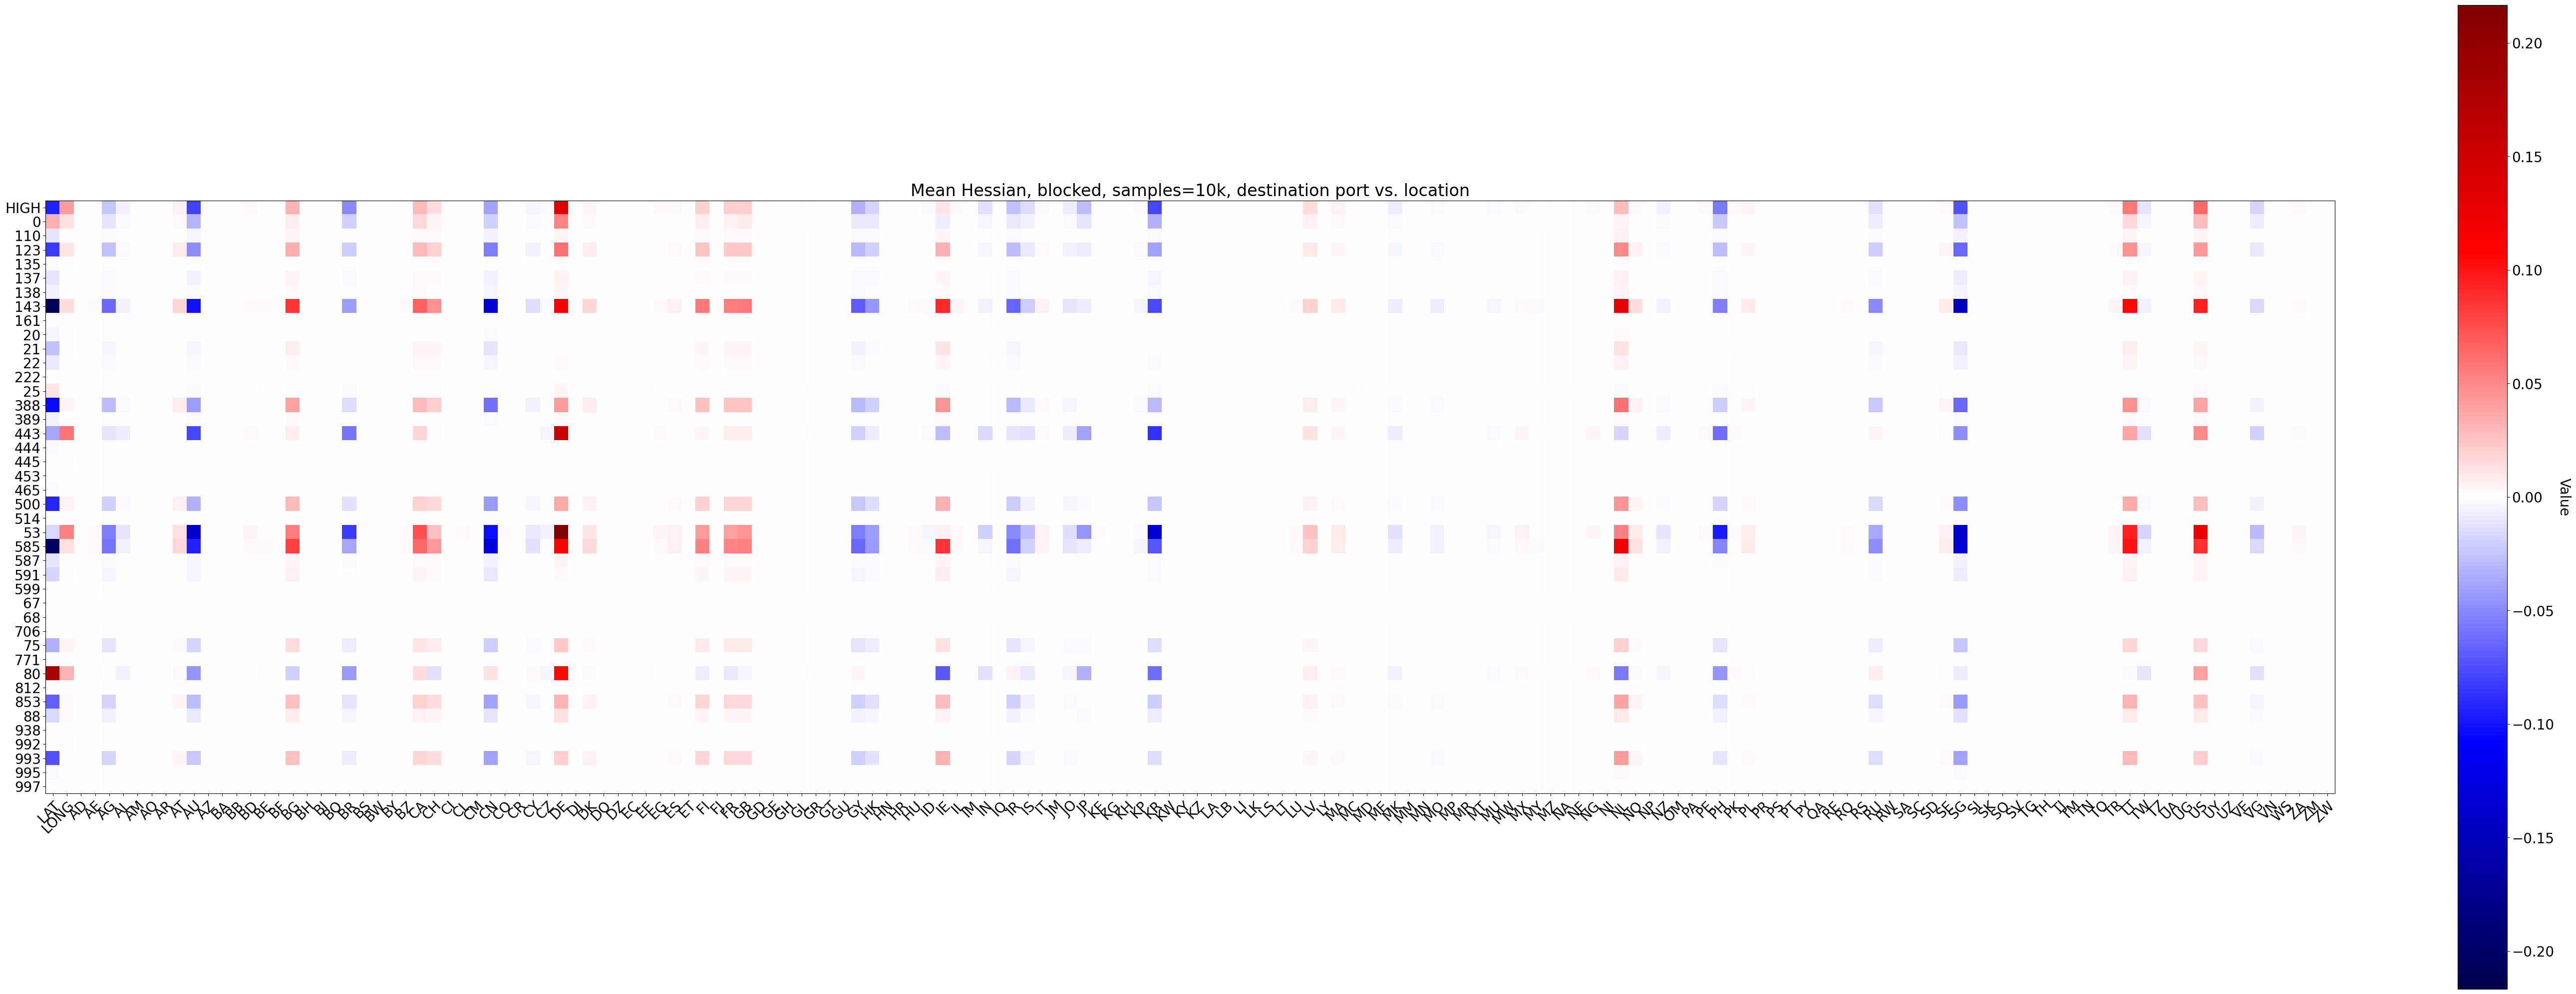

In [25]:
plot = iptoport
x_names = ipfeaturenames
y_names = portfeaturenames

fig, ax = plt.subplots(figsize=(52, 52))
matplotlib.rcParams.update({'font.size': 20})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.02)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="b")
'''

ax.set_title("Mean Hessian, blocked, samples=10k, destination port vs. location")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

In [26]:
short_names = []
for item in feature_names:
    short_names.append(item.removeprefix('inside_'))

In [27]:
# top feature attributions
top10_grads = np.flip(np.sort(np.abs(avg_gradients))[-20:])
avg_gradients.shape

(246,)

In [28]:
print(top10_grads)

[1.3209271  1.1260004  1.0151772  0.9634426  0.949271   0.8031542
 0.7356974  0.72487247 0.71340877 0.7008425  0.6495795  0.6391647
 0.52507436 0.5138083  0.46952713 0.4355466  0.42460907 0.41434813
 0.41289136 0.41218174]


In [29]:
top10_index = []
for item in top10_grads:
    top10_index.append(np.argwhere(np.abs(avg_gradients) == item).ravel()[0])
#top10_index = np.argwhere(avg_gradients >= np.min(top10_grads, 0)).squeeze()
print(top10_index)

[227, 10, 211, 181, 228, 1, 8, 0, 3, 6, 9, 204, 220, 202, 207, 174, 121, 145, 218, 237]


In [30]:
top10_names = []
for index in top10_index:
    top10_names.append(feature_names[index])
    
for i in range(len(top10_index)):
    idx = top10_index[i]
    print(i+1,'. ', top10_names[i], ': ', avg_gradients[idx], sep='')

1. inside_port_dst_53: -1.3209271
2. inside_ip_protocol_6: -1.1260004
3. inside_port_dst_143: 1.0151772
4. inside_port_src_53: -0.9634426
5. inside_port_dst_585: 0.949271
6. inside_ip_dst_LAT: 0.8031542
7. inside_ip_protocol_17: 0.7356974
8. inside_ip_len: -0.72487247
9. inside_ip_ttl: -0.71340877
10. inside_ip_protocol_1: 0.7008425
11. inside_ip_protocol_50: -0.6495795
12. inside_port_dst_HIGH: -0.6391647
13. inside_port_dst_443: 0.52507436
14. inside_port_src_949: 0.5138083
15. inside_port_dst_123: 0.46952713
16. inside_port_src_123: 0.4355466
17. inside_ip_dst_NL: -0.42460907
18. inside_ip_dst_SG: 0.41434813
19. inside_port_dst_388: -0.41289136
20. inside_port_dst_80: 0.41218174


In [31]:
num_features = len(avg_gradients)

top10_interaction_matrix = np.zeros((len(top10_index),num_features))
a = 0
for i in top10_index:
    for j in range(num_features):
        top10_interaction_matrix[a,j] = grad_sign[i] *  avg_hessian[i,j]
    a+=1

In [32]:
top10_interaction_matrix.shape

(20, 246)

In [33]:
a = 0
xnames = []
ynames = []
for i in top10_index:
    for j in range(num_features):
        print(short_names[i],',\t', short_names[j], '\t:', top10_interaction_matrix[a][j])
    ynames.append(short_names[i])
    a+=1

port_dst_53 ,	 ip_len 	: 0.4509749114513397
port_dst_53 ,	 ip_dst_LAT 	: -0.016304627060890198
port_dst_53 ,	 ip_dst_LONG 	: 0.05305185541510582
port_dst_53 ,	 ip_ttl 	: -0.43844935297966003
port_dst_53 ,	 tcp_win_size 	: -0.016880495473742485
port_dst_53 ,	 ip_protocol_0 	: 4.4673621044091495e-36
port_dst_53 ,	 ip_protocol_1 	: -0.31931042671203613
port_dst_53 ,	 ip_protocol_103 	: -3.244249613899316e-35
port_dst_53 ,	 ip_protocol_17 	: 0.3142692744731903
port_dst_53 ,	 ip_protocol_50 	: 0.16007556021213531
port_dst_53 ,	 ip_protocol_6 	: -0.3047792613506317
port_dst_53 ,	 ip_protocol_89 	: -2.0784783462327558e-35
port_dst_53 ,	 ip_dst_AD 	: 6.217299232957885e-05
port_dst_53 ,	 ip_dst_AE 	: 0.002618046011775732
port_dst_53 ,	 ip_dst_AG 	: -0.05436556413769722
port_dst_53 ,	 ip_dst_AL 	: -0.011181876063346863
port_dst_53 ,	 ip_dst_AM 	: 0.0001467167749069631
port_dst_53 ,	 ip_dst_AO 	: 0.00040284081478603184
port_dst_53 ,	 ip_dst_AR 	: 0.0011782563524320722
port_dst_53 ,	 ip_dst_AT 	: 

In [34]:
print(len(short_names))
print(len(ynames))

246
20


In [35]:
top10_interaction_matrix.shape

(20, 246)

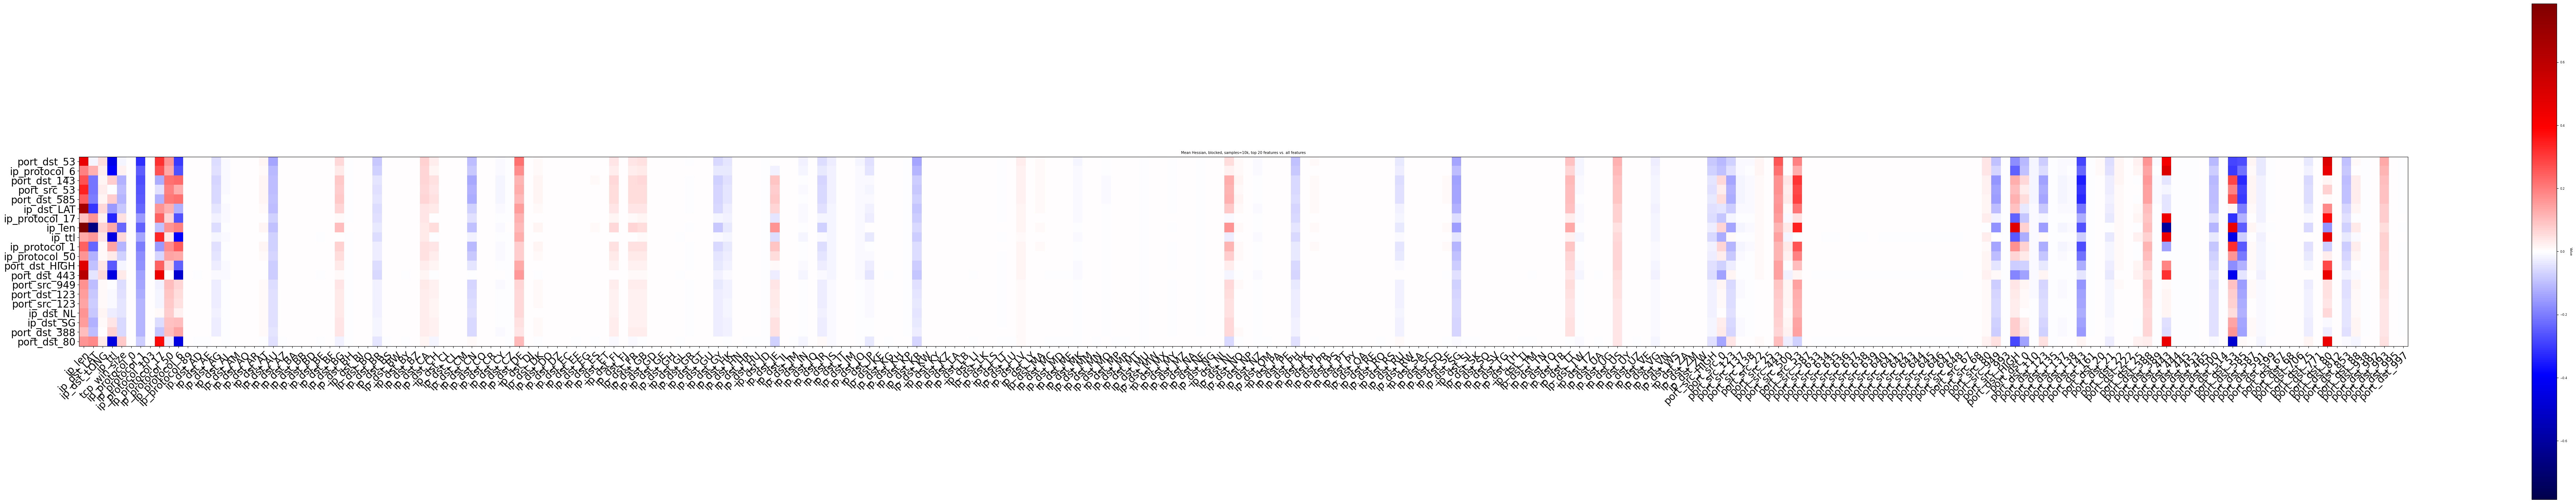

In [36]:
plot = top10_interaction_matrix
x_names = short_names
y_names = ynames

fig, ax = plt.subplots(figsize=(72, 72))
matplotlib.rcParams.update({'font.size': 6})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.01)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="b")
'''

ax.set_title("Mean Hessian, blocked, samples=10k, top 20 features vs. all features")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

In [37]:
# remove columns
threshold = 1e-2
indices = np.where(abs(top10_interaction_matrix[0,:]) < abs(threshold))
print(indices[0])
print(len(indices[0]))
a = np.delete(top10_interaction_matrix, indices, axis=1)
print(a.shape)
collapse_names = short_names.copy()

for index in indices[0]:
    collapse_names.remove(short_names[index])
    
print(len(collapse_names))

[  5   7  11  12  13  16  17  18  21  22  23  24  25  26  28  29  30  32
  33  34  35  38  39  40  42  43  45  47  49  50  51  52  53  54  55  57
  60  61  62  63  64  65  66  69  70  71  72  73  74  75  77  80  81  84
  85  86  87  89  90  91  92  93  94  95  96  97  98 100 101 102 103 104
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 122 123 125
 126 127 129 130 131 132 133 134 135 136 137 138 140 141 142 143 144 146
 147 148 149 150 151 152 153 154 155 156 159 160 161 163 164 165 167 168
 169 170 171 176 178 180 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 203 208 210 212 213 216 219 221 222 223 224
 226 231 232 233 234 236 238 241 242 244 245]
173
(20, 73)
73


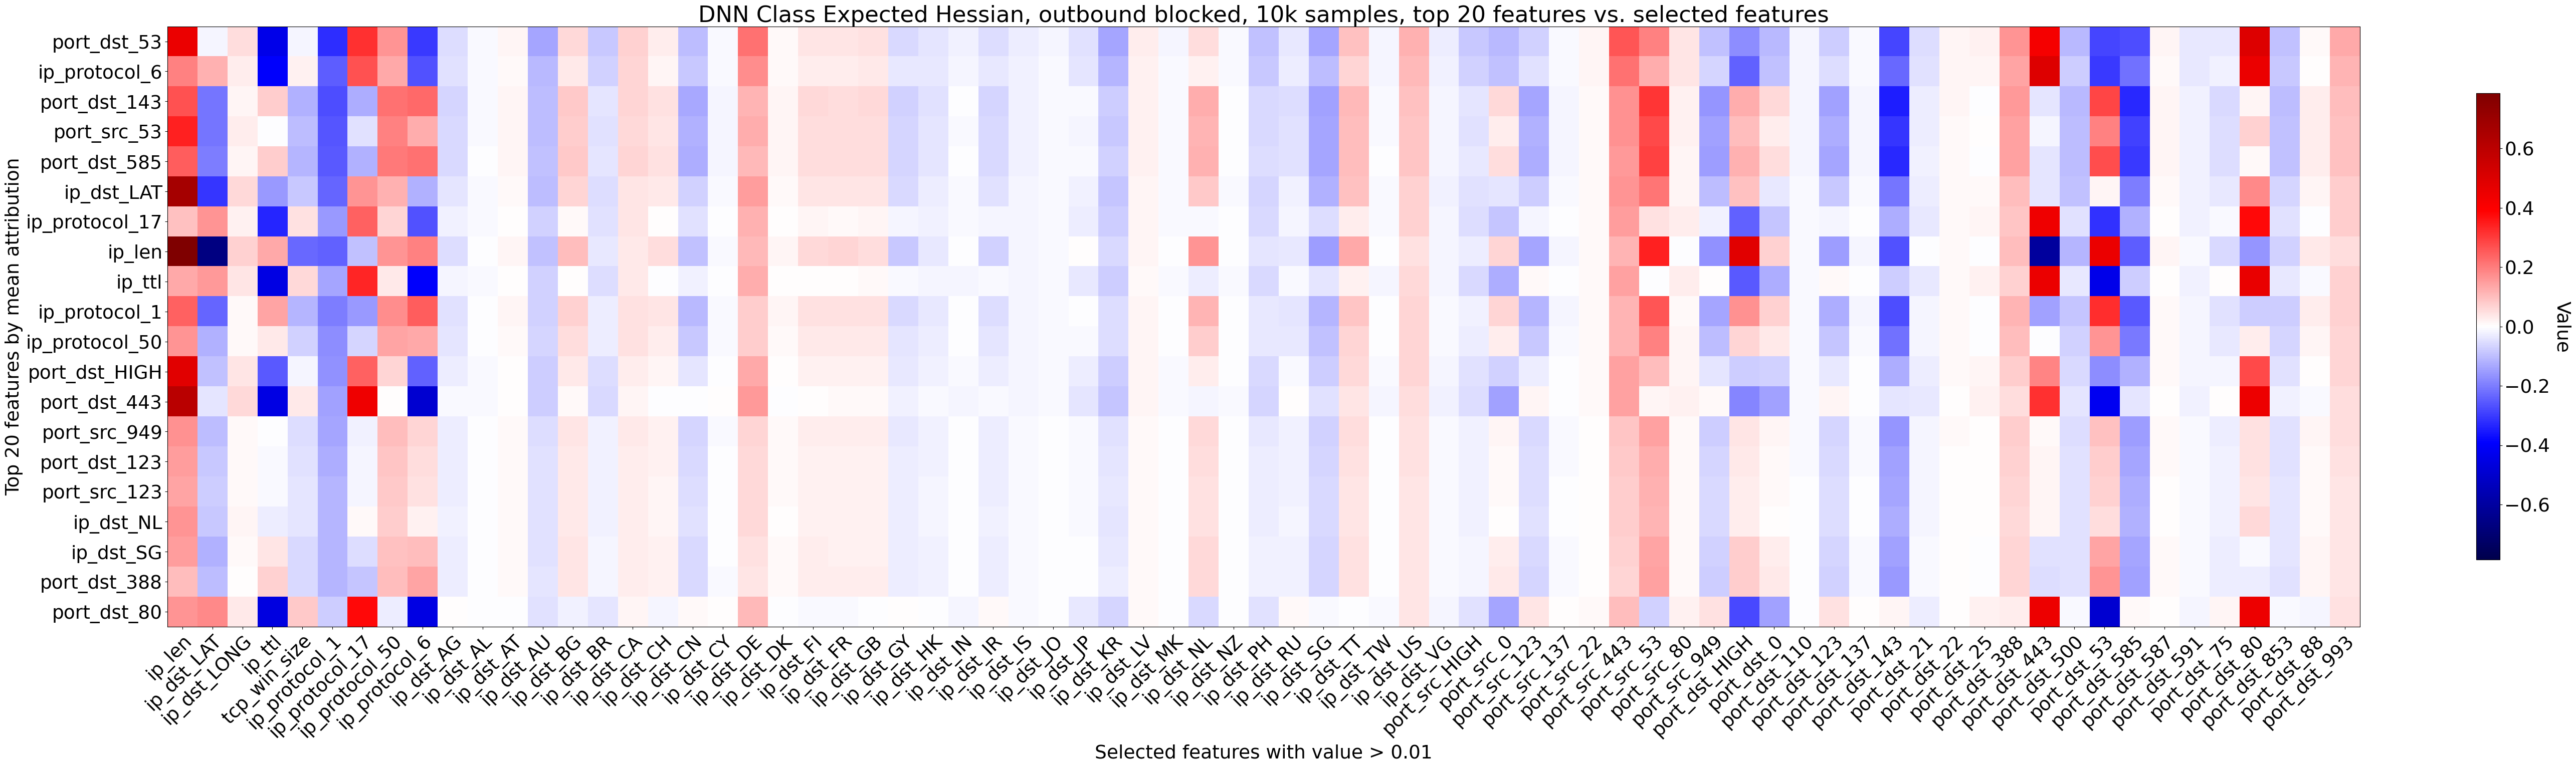

In [42]:
plot = a
x_names = collapse_names
y_names = ynames

fig, ax = plt.subplots(figsize=(52, 52))
matplotlib.rcParams.update({'font.size': 27})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.01)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel('Top 20 features by mean attribution')
plt.xlabel('Selected features with value > 0.01')
'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="w")
'''
ax.set_title("DNN Class Expected Hessian, outbound blocked, 10k samples, top 20 features vs. selected features")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

# allowed

In [74]:
HESSIANS_PATH = '/smallwork/alexander.huang/vanilla_hessians/outbound/10000/49595431/allow_vanilla_interactions.npy'
GRADIENTS_PATH = '/smallwork/alexander.huang/saliency_maps/outbound/all/49595429/allow_saliency_maps.npy'
DATA_DIR = '/data/alexander.huang/data/0903_data/test_drop/outbound_x_test.parq'

df = pd.read_parquet(DATA_DIR)
feature_names = df.columns.tolist()

In [75]:
allowed_hessians = np.load(HESSIANS_PATH)
allowed_hessians.shape

(10000, 246, 246)

In [76]:
allowed_gradients = np.load(GRADIENTS_PATH)
allowed_gradients.shape

(3478851, 246)

In [77]:
avg_gradients = np.mean(allowed_gradients, axis=0)
print(avg_gradients.shape)


(246,)


In [78]:
grad_sign = np.sign(avg_gradients)
print(grad_sign)

[ 1. -1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1.
  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
 -1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.
  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.
  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.
  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.
  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1.
  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1.]


In [79]:
avg_hessian = np.mean(allowed_hessians, axis=0)
std_hessian = np.std(allowed_hessians, axis=0)
print(avg_hessian.shape)
print(avg_hessian)

(246, 246)
[[-1.10988326e-01  9.07307863e-02 -4.20812139e-05 ... -4.51484136e-02
  -1.96449435e-03  1.13911330e-04]
 [ 9.07336771e-02 -1.18197426e-01 -2.41263700e-03 ...  4.11543623e-02
   1.87060470e-03 -1.28521337e-04]
 [-3.95575953e-05 -2.41543422e-03  1.41092634e-03 ... -6.86209940e-04
  -2.23476618e-05 -3.99965387e-07]
 ...
 [-4.51490246e-02  4.11537737e-02 -6.87342777e-04 ... -2.01469027e-02
  -8.77335551e-04  5.04967320e-05]
 [-1.96452043e-03  1.87058654e-03 -2.23969473e-05 ... -8.77335260e-04
  -3.83769875e-05  2.25500753e-06]
 [ 1.13911236e-04 -1.28517044e-04 -3.96825925e-07 ...  5.04957861e-05
   2.25495910e-06 -1.44140841e-07]]


In [80]:
interaction_matrix = np.zeros((246,246))
num_features = len(avg_gradients)

# feature by row, so lock each row
for i in range(num_features):
    for j in range(num_features):
        interaction_matrix[i,j] = grad_sign[i] *  avg_hessian[i,j]

In [81]:
print(interaction_matrix)

[[-1.10988326e-01  9.07307863e-02 -4.20812139e-05 ... -4.51484136e-02
  -1.96449435e-03  1.13911330e-04]
 [-9.07336771e-02  1.18197426e-01  2.41263700e-03 ... -4.11543623e-02
  -1.87060470e-03  1.28521337e-04]
 [-3.95575953e-05 -2.41543422e-03  1.41092634e-03 ... -6.86209940e-04
  -2.23476618e-05 -3.99965387e-07]
 ...
 [-4.51490246e-02  4.11537737e-02 -6.87342777e-04 ... -2.01469027e-02
  -8.77335551e-04  5.04967320e-05]
 [-1.96452043e-03  1.87058654e-03 -2.23969473e-05 ... -8.77335260e-04
  -3.83769875e-05  2.25500753e-06]
 [-1.13911236e-04  1.28517044e-04  3.96825925e-07 ... -5.04957861e-05
  -2.25495910e-06  1.44140841e-07]]


In [82]:
print(feature_names)

['inside_ip_len', 'inside_ip_dst_LAT', 'inside_ip_dst_LONG', 'inside_ip_ttl', 'inside_tcp_win_size', 'inside_ip_protocol_0', 'inside_ip_protocol_1', 'inside_ip_protocol_103', 'inside_ip_protocol_17', 'inside_ip_protocol_50', 'inside_ip_protocol_6', 'inside_ip_protocol_89', 'inside_ip_dst_AD', 'inside_ip_dst_AE', 'inside_ip_dst_AG', 'inside_ip_dst_AL', 'inside_ip_dst_AM', 'inside_ip_dst_AO', 'inside_ip_dst_AR', 'inside_ip_dst_AT', 'inside_ip_dst_AU', 'inside_ip_dst_AZ', 'inside_ip_dst_BA', 'inside_ip_dst_BB', 'inside_ip_dst_BD', 'inside_ip_dst_BE', 'inside_ip_dst_BF', 'inside_ip_dst_BG', 'inside_ip_dst_BH', 'inside_ip_dst_BI', 'inside_ip_dst_BO', 'inside_ip_dst_BR', 'inside_ip_dst_BS', 'inside_ip_dst_BW', 'inside_ip_dst_BY', 'inside_ip_dst_BZ', 'inside_ip_dst_CA', 'inside_ip_dst_CH', 'inside_ip_dst_CI', 'inside_ip_dst_CL', 'inside_ip_dst_CM', 'inside_ip_dst_CN', 'inside_ip_dst_CO', 'inside_ip_dst_CR', 'inside_ip_dst_CY', 'inside_ip_dst_CZ', 'inside_ip_dst_DE', 'inside_ip_dst_DJ', 'insid

In [83]:
ipfeatureindex = []
ipfeaturenames = []
for ele in feature_names:
    if ele.startswith('inside_ip_dst_'):
        #print(ele)
        name = ele.removeprefix('inside_ip_dst_')
        ipfeaturenames.append(name)
        ipfeatureindex.append(feature_names.index(ele))
print(len(ipfeaturenames))
print(len(ipfeatureindex))

162
162


In [84]:
portfeatureindex = []
portfeaturenames = []
for ele in feature_names:
    if ele.startswith('inside_port_src_'):
        name = ele.removeprefix('inside_port_src_')
        #print(ele)
        portfeaturenames.append(name)
        portfeatureindex.append(feature_names.index(ele))
print(len(portfeaturenames))
print(len(portfeatureindex))

32
32


In [85]:
iptoport = np.zeros(shape=(len(portfeatureindex),len(ipfeatureindex)))
a = 0
for i in portfeatureindex:
    b=0
    for j in ipfeatureindex:
        iptoport[a,b] = interaction_matrix[i,j]
        b+=1
    a+=1

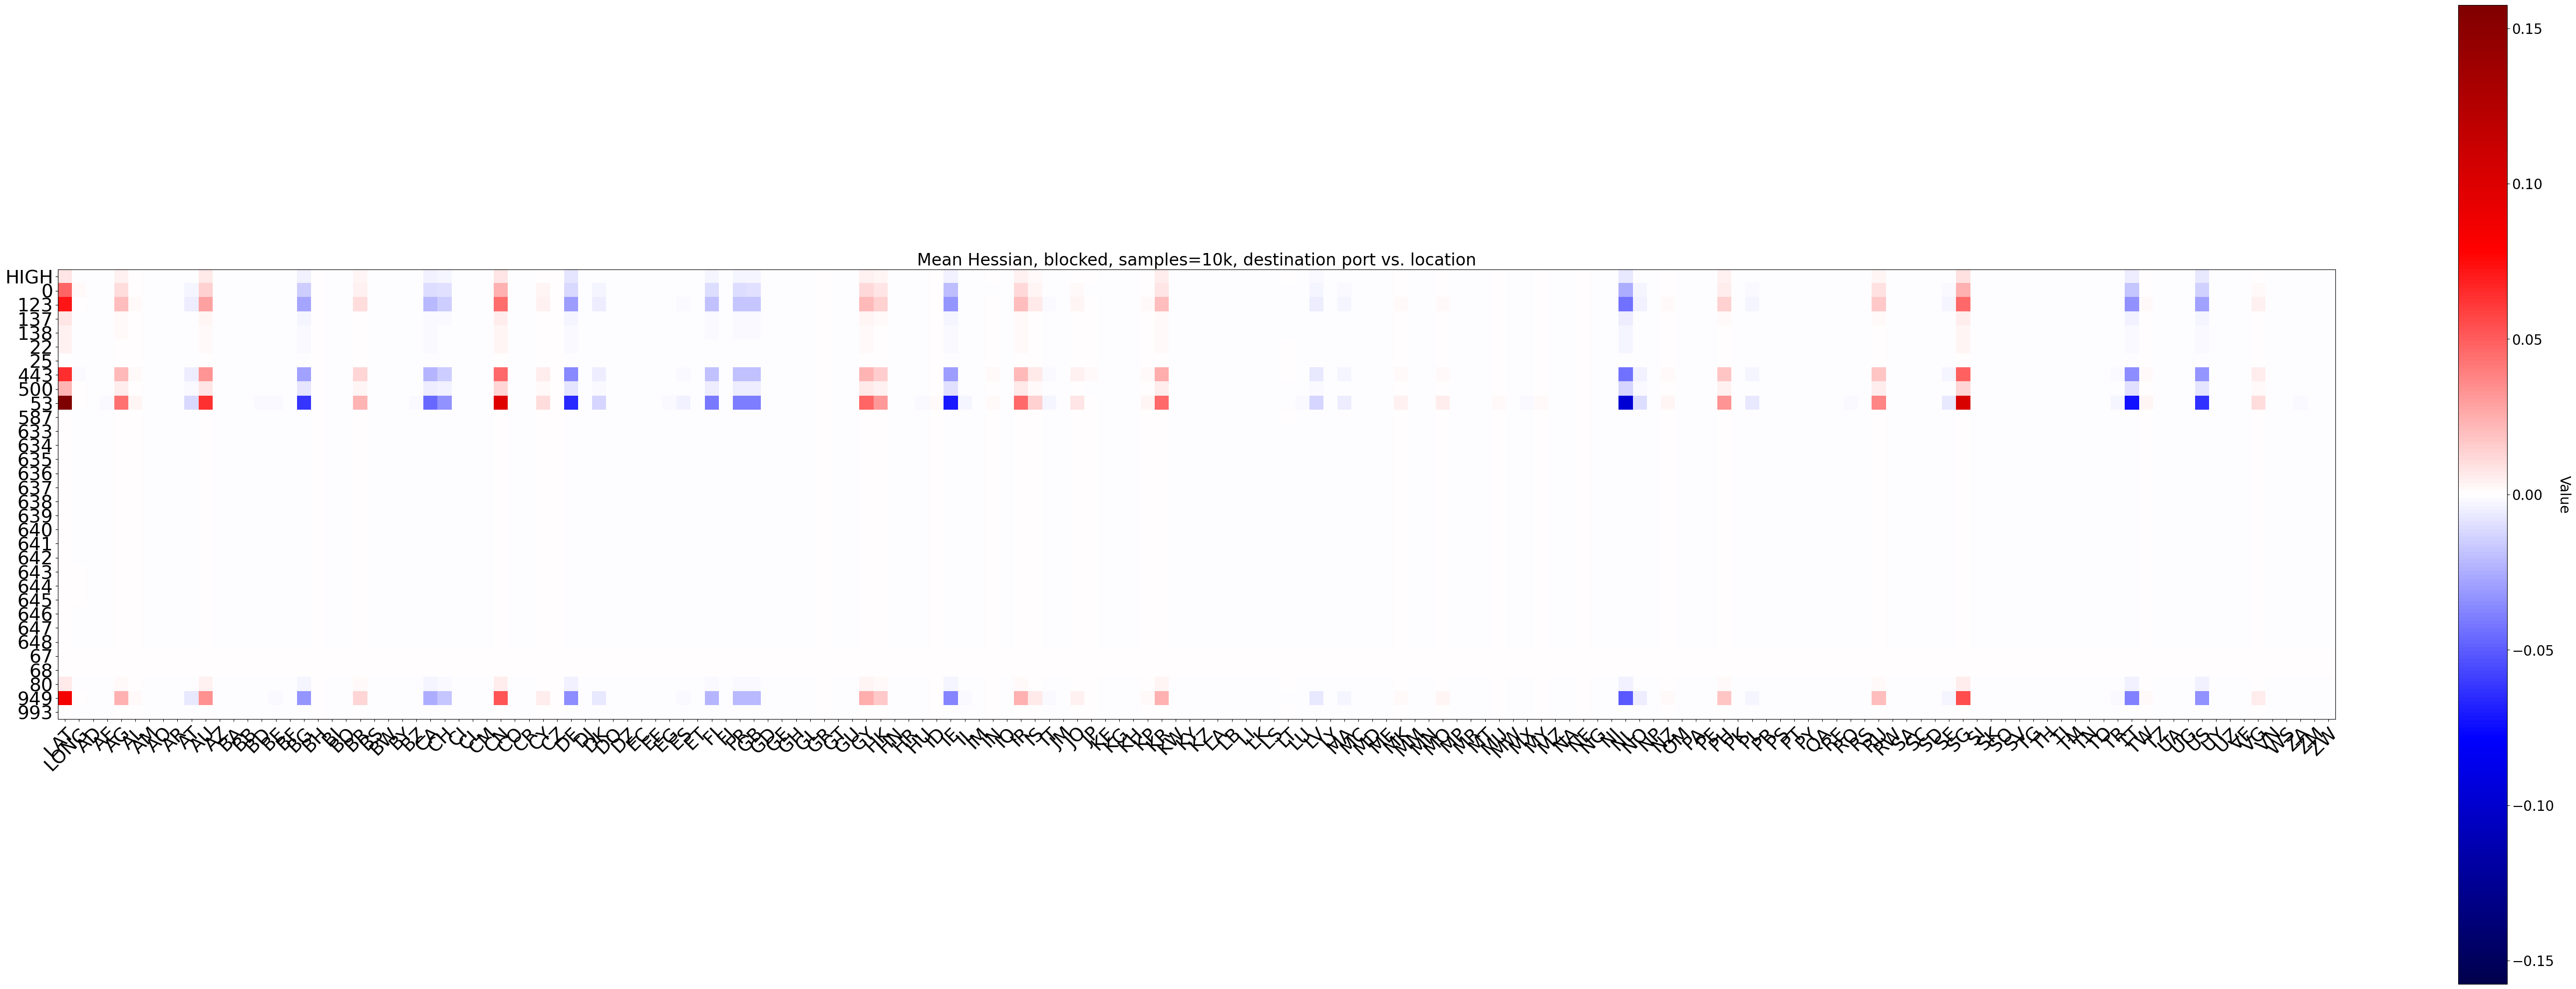

In [86]:
plot = iptoport
x_names = ipfeaturenames
y_names = portfeaturenames

fig, ax = plt.subplots(figsize=(52, 52))
matplotlib.rcParams.update({'font.size': 20})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.02)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="b")
'''

ax.set_title("Mean Hessian, blocked, samples=10k, destination port vs. location")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

In [87]:
short_names = []
for item in feature_names:
    short_names.append(item.removeprefix('inside_'))

In [88]:
# top feature attributions
top10_grads = np.flip(np.sort(np.abs(avg_gradients))[-20:])
avg_gradients.shape

(246,)

In [89]:
print(top10_grads)

[0.0961066  0.09012788 0.09010026 0.08662078 0.07846411 0.0718925
 0.06349483 0.06126349 0.0580161  0.04722565 0.0459938  0.04322489
 0.04187524 0.04165284 0.04038652 0.03977336 0.03872498 0.03787797
 0.03659649 0.03447042]


In [90]:
top10_index = []
for item in top10_grads:
    top10_index.append(np.argwhere(np.abs(avg_gradients) == item).ravel()[0])
#top10_index = np.argwhere(avg_gradients >= np.min(top10_grads, 0)).squeeze()
print(top10_index)

[211, 228, 227, 181, 10, 6, 0, 9, 1, 8, 202, 179, 207, 218, 204, 145, 174, 41, 121, 3]


In [91]:
top10_names = []
for index in top10_index:
    top10_names.append(feature_names[index])
    
for i in range(len(top10_index)):
    idx = top10_index[i]
    print(i+1,'. ', top10_names[i], ': ', avg_gradients[idx], sep='')

1. inside_port_dst_143: -0.0961066
2. inside_port_dst_585: -0.09012788
3. inside_port_dst_53: 0.09010026
4. inside_port_src_53: 0.08662078
5. inside_ip_protocol_6: 0.078464106
6. inside_ip_protocol_1: -0.0718925
7. inside_ip_len: 0.06349483
8. inside_ip_protocol_50: 0.061263487
9. inside_ip_dst_LAT: -0.058016103
10. inside_ip_protocol_17: -0.04722565
11. inside_port_src_949: -0.045993797
12. inside_port_src_443: 0.043224886
13. inside_port_dst_123: -0.041875236
14. inside_port_dst_388: 0.041652843
15. inside_port_dst_HIGH: 0.040386517
16. inside_ip_dst_SG: -0.039773364
17. inside_port_src_123: -0.038724985
18. inside_ip_dst_CN: -0.037877966
19. inside_ip_dst_NL: 0.03659649
20. inside_ip_ttl: 0.034470417


In [92]:
num_features = len(avg_gradients)

top10_interaction_matrix = np.zeros((len(top10_index),num_features))
a = 0
for i in top10_index:
    for j in range(num_features):
        top10_interaction_matrix[a,j] = grad_sign[i] *  avg_hessian[i,j]
    a+=1

In [93]:
top10_interaction_matrix.shape

(20, 246)

In [94]:
a = 0
xnames = []
ynames = []
for i in top10_index:
    for j in range(num_features):
        print(short_names[i],',\t', short_names[j], '\t:', top10_interaction_matrix[a][j])
    ynames.append(short_names[i])
    a+=1

port_dst_143 ,	 ip_len 	: -0.165260449051857
port_dst_143 ,	 ip_dst_LAT 	: 0.16995204985141754
port_dst_143 ,	 ip_dst_LONG 	: -0.000884318258613348
port_dst_143 ,	 ip_ttl 	: -0.12098722159862518
port_dst_143 ,	 tcp_win_size 	: 0.09377840161323547
port_dst_143 ,	 ip_protocol_0 	: -7.236972870782535e-36
port_dst_143 ,	 ip_protocol_1 	: 0.20177125930786133
port_dst_143 ,	 ip_protocol_103 	: 1.719231660587118e-35
port_dst_143 ,	 ip_protocol_17 	: 0.1530427634716034
port_dst_143 ,	 ip_protocol_50 	: -0.17590709030628204
port_dst_143 ,	 ip_protocol_6 	: -0.24515563249588013
port_dst_143 ,	 ip_protocol_89 	: -7.45861640583022e-36
port_dst_143 ,	 ip_dst_AD 	: -7.102861854946241e-05
port_dst_143 ,	 ip_dst_AE 	: -0.002463466487824917
port_dst_143 ,	 ip_dst_AG 	: 0.049267444759607315
port_dst_143 ,	 ip_dst_AL 	: 0.004236729349941015
port_dst_143 ,	 ip_dst_AM 	: -0.00011984712182311341
port_dst_143 ,	 ip_dst_AO 	: -0.00014701821783091873
port_dst_143 ,	 ip_dst_AR 	: -0.0005969236372038722
port_dst

In [95]:
print(len(short_names))
print(len(ynames))

246
20


In [96]:
top10_interaction_matrix.shape

(20, 246)

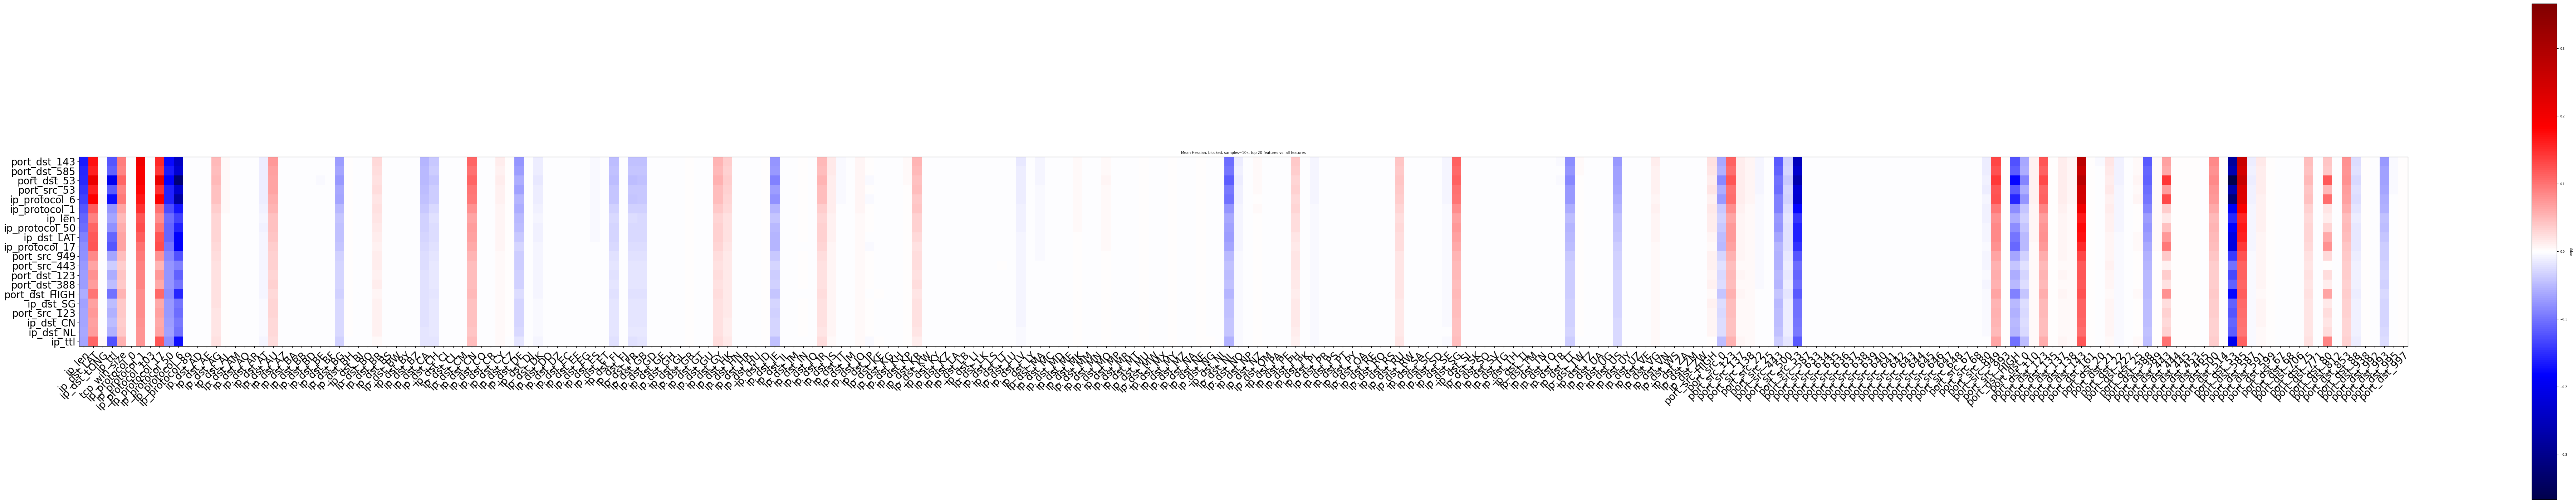

In [97]:
plot = top10_interaction_matrix
x_names = short_names
y_names = ynames

fig, ax = plt.subplots(figsize=(72, 72))
matplotlib.rcParams.update({'font.size': 6})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.01)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="b")
'''

ax.set_title("Mean Hessian, blocked, samples=10k, top 20 features vs. all features")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

In [98]:
# remove columns
threshold = 1e-2
indices = np.where(abs(top10_interaction_matrix[0,:]) < abs(threshold))
print(indices[0])
print(len(indices[0]))
a = np.delete(top10_interaction_matrix, indices, axis=1)
print(a.shape)
collapse_names = short_names.copy()

for index in indices[0]:
    collapse_names.remove(short_names[index])
    
print(len(collapse_names))

[  2   5   7  11  12  13  15  16  17  18  21  22  23  24  25  26  28  29
  30  32  33  34  35  38  39  40  42  43  45  47  49  50  51  52  53  54
  55  57  60  61  62  63  64  65  66  69  70  71  72  74  75  76  77  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 123 124 125 126 127 129 130 131 132 133 134 135 136 137 138 140
 141 142 143 144 146 147 148 149 150 151 152 153 154 155 156 158 159 160
 161 163 164 165 167 168 169 170 171 176 177 178 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 203 208 210 212 213
 215 216 217 219 221 222 223 224 226 231 232 233 234 236 238 241 242 244
 245]
181
(20, 65)
65


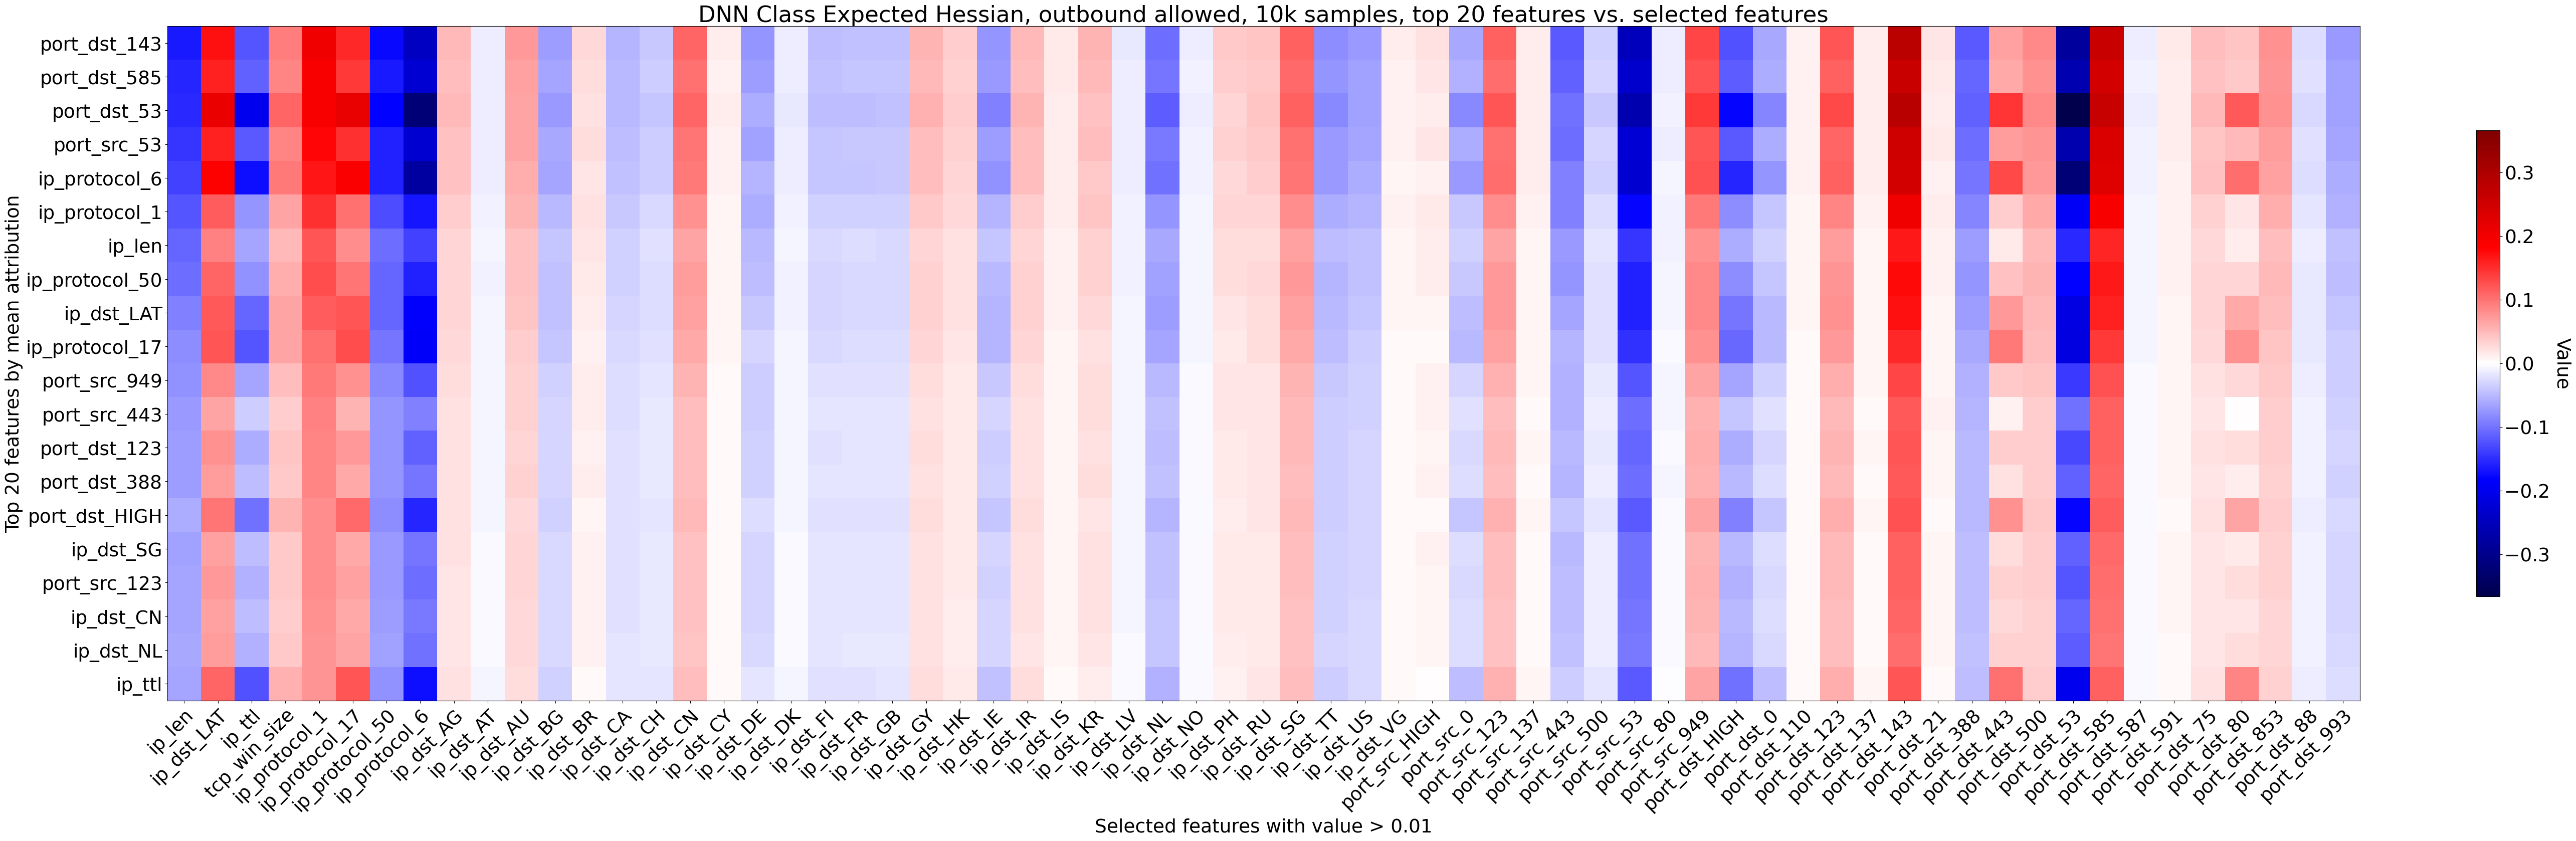

In [100]:
plot = a
x_names = collapse_names
y_names = ynames

fig, ax = plt.subplots(figsize=(52, 52))
matplotlib.rcParams.update({'font.size': 27})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.01)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel('Top 20 features by mean attribution')
plt.xlabel('Selected features with value > 0.01')
'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="w")
'''
ax.set_title("DNN Class Expected Hessian, outbound allowed, 10k samples, top 20 features vs. selected features")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

# Inbound

In [147]:
HESSIANS_PATH = '/smallwork/alexander.huang/vanilla_hessians/inbound/10000/49595430/block_vanilla_interactions.npy'
GRADIENTS_PATH = '/smallwork/alexander.huang/saliency_maps/inbound/all/49595428/block_saliency_maps.npy'
DATA_DIR = '/data/alexander.huang/data/0903_data/test_drop/inbound_x_test.parq'

df = pd.read_parquet(DATA_DIR)
feature_names = df.columns.tolist()

In [148]:
blocked_hessians = np.load(HESSIANS_PATH)
blocked_hessians.shape

(10000, 381, 381)

In [149]:
blocked_gradients = np.load(GRADIENTS_PATH)
blocked_gradients.shape

(543594, 381)

In [150]:
avg_gradients = np.mean(blocked_gradients, axis=0)
print(avg_gradients.shape)


(381,)


In [151]:
grad_sign = np.sign(avg_gradients)
print(grad_sign)

[-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.
  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.
 -1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1.
 -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1.  1.  1.
  1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.
  1.  1.  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1.
  1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.
 -1. -1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [152]:
avg_hessian = np.mean(blocked_hessians, axis=0)
std_hessian = np.std(blocked_hessians, axis=0)
print(avg_hessian.shape)
print(avg_hessian)

(381, 381)
[[ 2.1254328e-01 -1.5508635e-01 -7.6273631e-04 ... -3.3876900e-02
  -2.5022797e-02 -4.3511197e-02]
 [-1.5508097e-01 -4.2009604e-01 -2.0956513e-01 ... -7.0241629e-03
  -2.8920537e-03  8.6632352e-03]
 [-7.6028478e-04 -2.0956662e-01  3.1844118e-01 ... -1.0510165e-02
  -7.8550102e-03 -1.3263801e-02]
 ...
 [-3.3877343e-02 -7.0240479e-03 -1.0511144e-02 ... -2.6357272e-03
  -1.6739246e-03 -3.4799075e-04]
 [-2.5021983e-02 -2.8929915e-03 -7.8554507e-03 ... -1.6740334e-03
  -1.0542785e-03 -2.4935982e-05]
 [-4.3513421e-02  8.6625982e-03 -1.3265275e-02 ... -3.4795460e-04
  -2.4737519e-05  2.3150388e-03]]


In [153]:
interaction_matrix = np.zeros((381,381))
num_features = len(avg_gradients)

# feature by row, so lock each row
for i in range(num_features):
    for j in range(num_features):
        interaction_matrix[i,j] = grad_sign[i] *  avg_hessian[i,j]

In [154]:
print(interaction_matrix)

[[-2.12543279e-01  1.55086353e-01  7.62736308e-04 ...  3.38768996e-02
   2.50227973e-02  4.35111970e-02]
 [ 1.55080974e-01  4.20096040e-01  2.09565133e-01 ...  7.02416291e-03
   2.89205369e-03 -8.66323523e-03]
 [-7.60284776e-04 -2.09566623e-01  3.18441182e-01 ... -1.05101652e-02
  -7.85501022e-03 -1.32638011e-02]
 ...
 [-3.38773429e-02 -7.02404790e-03 -1.05111441e-02 ... -2.63572717e-03
  -1.67392462e-03 -3.47990746e-04]
 [-2.50219833e-02 -2.89299153e-03 -7.85545073e-03 ... -1.67403335e-03
  -1.05427846e-03 -2.49359819e-05]
 [-4.35134210e-02  8.66259821e-03 -1.32652754e-02 ... -3.47954599e-04
  -2.47375192e-05  2.31503882e-03]]


In [155]:
ipfeatureindex = []
ipfeaturenames = []
for ele in feature_names:
    if ele.startswith('outside_ip_src_'):
        #print(ele)
        name = ele.removeprefix('outside_ip_src_')
        ipfeaturenames.append(name)
        ipfeatureindex.append(feature_names.index(ele))
print(len(ipfeaturenames))
print(len(ipfeatureindex))

143
143


In [156]:
portfeatureindex = []
portfeaturenames = []
for ele in feature_names:
    if ele.startswith('outside_port_src_'):
        name = ele.removeprefix('outside_port_src_')
        #print(ele)
        portfeaturenames.append(name)
        portfeatureindex.append(feature_names.index(ele))
print(len(portfeaturenames))
print(len(portfeatureindex))

21
21


In [157]:
iptoport = np.zeros(shape=(len(portfeatureindex),len(ipfeatureindex)))
a = 0
for i in portfeatureindex:
    b=0
    for j in ipfeatureindex:
        iptoport[a,b] = interaction_matrix[i,j]
        b+=1
    a+=1

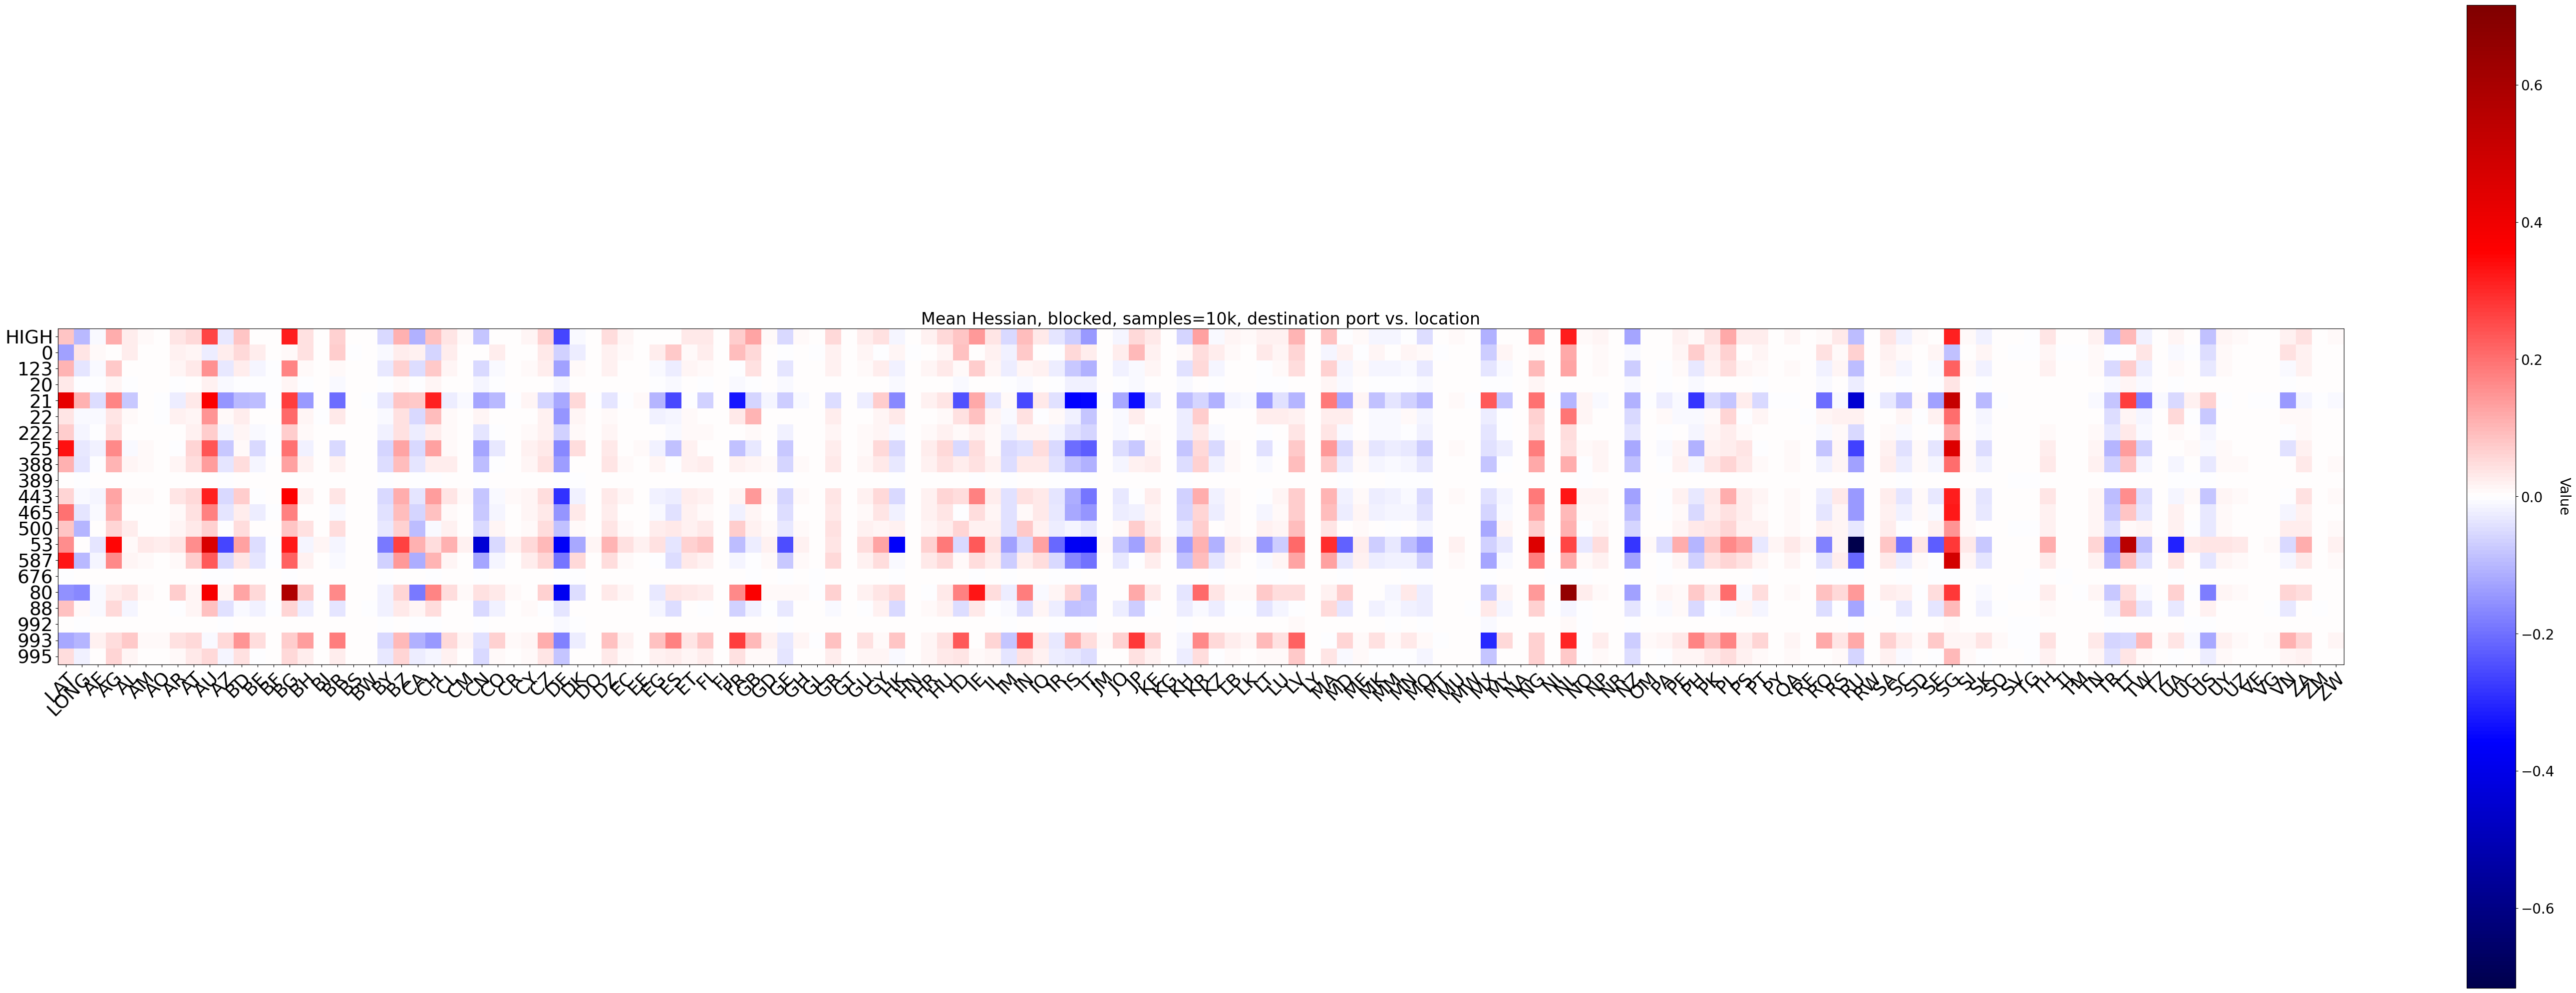

In [158]:
plot = iptoport
x_names = ipfeaturenames
y_names = portfeaturenames

fig, ax = plt.subplots(figsize=(52, 52))
matplotlib.rcParams.update({'font.size': 20})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.02)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="b")
'''

ax.set_title("Mean Hessian, blocked, samples=10k, destination port vs. location")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

In [159]:
short_names = []
for item in feature_names:
    short_names.append(item.removeprefix('outside_'))

In [160]:
# top feature attributions
top10_grads = np.flip(np.sort(np.abs(avg_gradients))[-20:])
avg_gradients.shape

(381,)

In [161]:
print(top10_grads)

[0.9440721  0.87091404 0.6190797  0.6150029  0.5723791  0.5685847
 0.55828905 0.5520477  0.5275082  0.4998415  0.49619323 0.48698092
 0.44962156 0.44344342 0.44107243 0.42980725 0.4262788  0.41256237
 0.4001467  0.38027176]


In [162]:
top10_index = []
for item in top10_grads:
    top10_index.append(np.argwhere(np.abs(avg_gradients) == item).ravel()[0])
#top10_index = np.argwhere(avg_gradients >= np.min(top10_grads, 0)).squeeze()
print(top10_index)

[164, 120, 137, 232, 3, 202, 34, 161, 155, 165, 158, 100, 8, 71, 17, 60, 151, 72, 11, 296]


In [163]:
top10_names = []
for index in top10_index:
    top10_names.append(feature_names[index])
    
for i in range(len(top10_index)):
    idx = top10_index[i]
    print(i+1,'. ', top10_names[i], ': ', avg_gradients[idx], sep='')

1. outside_port_src_53: -0.9440721
2. outside_ip_src_RU: 0.87091404
3. outside_ip_src_TT: -0.6190797
4. outside_port_dst_22: -0.6150029
5. outside_ip_ttl: 0.5723791
6. outside_port_dst_123: 0.5685847
7. outside_ip_src_CN: 0.55828905
8. outside_port_src_443: -0.5520477
9. outside_port_src_21: 0.5275082
10. outside_port_src_587: -0.4998415
11. outside_port_src_25: -0.49619323
12. outside_ip_src_NG: -0.48698092
13. outside_ip_protocol_50: -0.44962156
14. outside_ip_src_IS: 0.44344342
15. outside_ip_src_AU: -0.44107243
16. outside_ip_src_HK: 0.42980725
17. outside_port_src_HIGH: 0.4262788
18. outside_ip_src_IT: 0.41256237
19. outside_ip_src_AG: -0.4001467
20. outside_port_dst_58: 0.38027176


In [164]:
num_features = len(avg_gradients)

top10_interaction_matrix = np.zeros((len(top10_index),num_features))
a = 0
for i in top10_index:
    for j in range(num_features):
        top10_interaction_matrix[a,j] = grad_sign[i] *  avg_hessian[i,j]
    a+=1

In [165]:
top10_interaction_matrix.shape

(20, 381)

In [166]:
a = 0
xnames = []
ynames = []
for i in top10_index:
    for j in range(num_features):
        print(short_names[i],',\t', short_names[j], '\t:', top10_interaction_matrix[a][j])
    ynames.append(short_names[i])
    a+=1

port_src_53 ,	 ip_len 	: -0.010731703601777554
port_src_53 ,	 ip_src_LAT 	: 0.15853364765644073
port_src_53 ,	 ip_src_LONG 	: 0.004719471093267202
port_src_53 ,	 ip_ttl 	: -0.5029077529907227
port_src_53 ,	 tcp_win_size 	: 0.2730296850204468
port_src_53 ,	 ip_protocol_0 	: 0.26691386103630066
port_src_53 ,	 ip_protocol_17 	: -0.03901957347989082
port_src_53 ,	 ip_protocol_47 	: -0.08681318908929825
port_src_53 ,	 ip_protocol_50 	: 0.381393164396286
port_src_53 ,	 ip_protocol_6 	: -0.005060531664639711
port_src_53 ,	 ip_src_AE 	: -0.03442135453224182
port_src_53 ,	 ip_src_AG 	: 0.3512978255748749
port_src_53 ,	 ip_src_AL 	: 0.006040048319846392
port_src_53 ,	 ip_src_AM 	: 0.0331474207341671
port_src_53 ,	 ip_src_AO 	: 0.023176873102784157
port_src_53 ,	 ip_src_AR 	: 0.03723577782511711
port_src_53 ,	 ip_src_AT 	: 0.1571720689535141
port_src_53 ,	 ip_src_AU 	: 0.4593423902988434
port_src_53 ,	 ip_src_AZ 	: -0.26191940903663635
port_src_53 ,	 ip_src_BD 	: 0.1323811262845993
port_src_53 ,	

In [167]:
print(len(short_names))
print(len(ynames))

381
20


In [168]:
top10_interaction_matrix.shape

(20, 381)

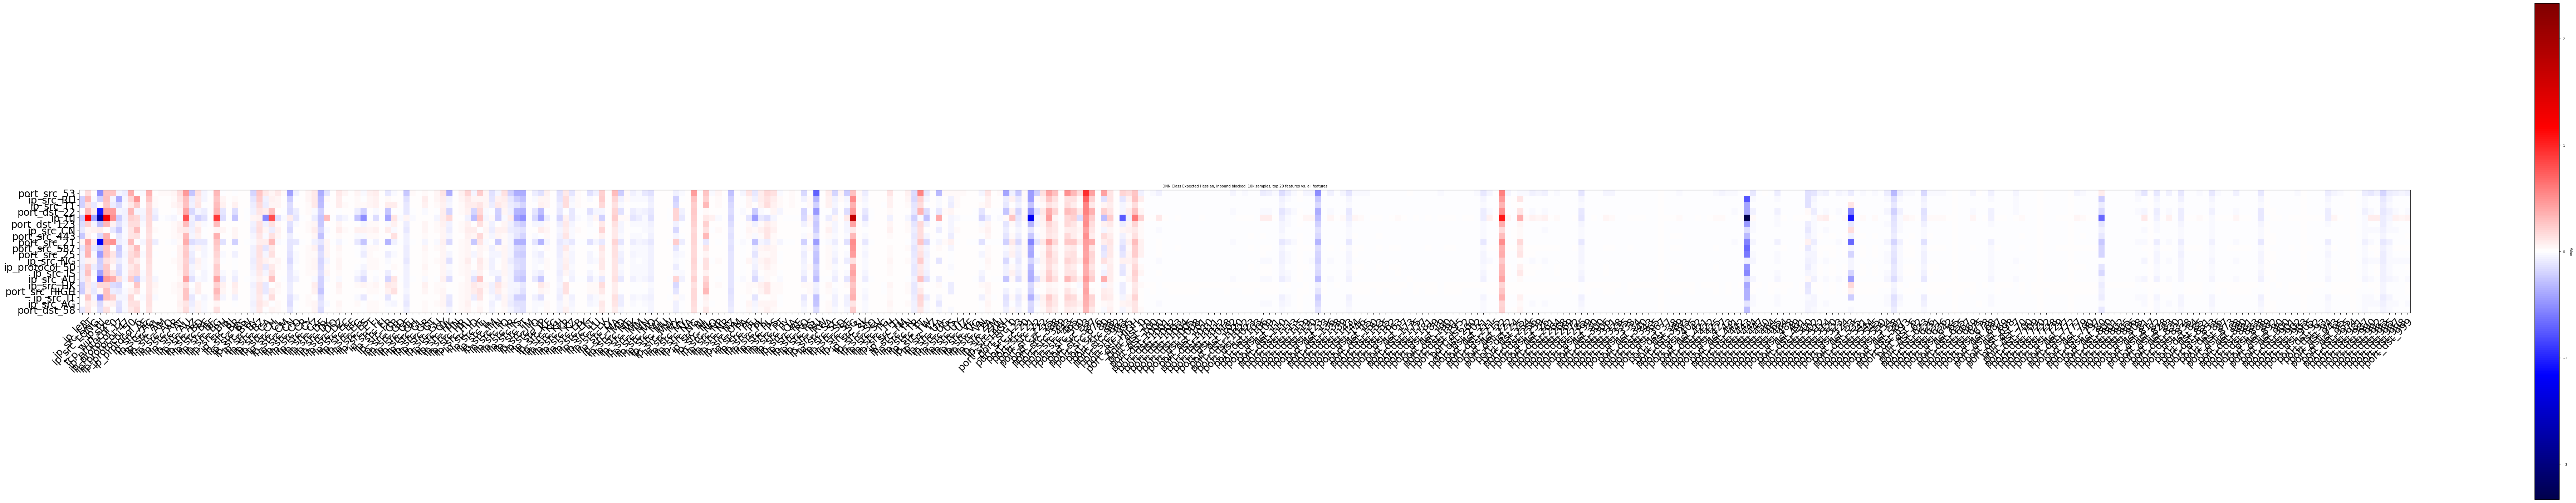

In [169]:
plot = top10_interaction_matrix
x_names = short_names
y_names = ynames

fig, ax = plt.subplots(figsize=(72, 72))
matplotlib.rcParams.update({'font.size': 6})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.01)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="b")
'''

ax.set_title("DNN Class Expected Hessian, inbound blocked, 10k samples, top 20 features vs. all features")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

In [173]:
# remove columns
threshold = 1e-1
indices = np.where(abs(top10_interaction_matrix[0,:]) < abs(threshold))
print(indices[0])
print(len(indices[0]))
a = np.delete(top10_interaction_matrix, indices, axis=1)
print(a.shape)
collapse_names = short_names.copy()

for index in indices[0]:
    collapse_names.remove(short_names[index])
    
print(len(collapse_names))

[  0   2   6   7   9  10  12  13  14  15  20  21  23  24  25  26  27  31
  33  35  36  37  38  41  43  44  45  46  47  48  49  50  51  52  54  55
  56  57  58  61  62  64  66  68  73  74  76  77  81  82  84  86  89  90
  91  92  94  95  96  97  98  99 101 103 104 105 107 108 111 114 115 116
 117 119 121 122 124 127 128 129 130 131 133 134 135 138 139 141 142 143
 144 145 146 147 149 150 152 154 160 166 169 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 197 198
 199 200 201 203 204 205 206 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 230 231 233 234 235 236 237 238
 239 240 241 242 243 244 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 274 275 276
 277 278 279 280 281 284 285 286 287 288 289 290 291 292 293 294 295 297
 298 299 300 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 32

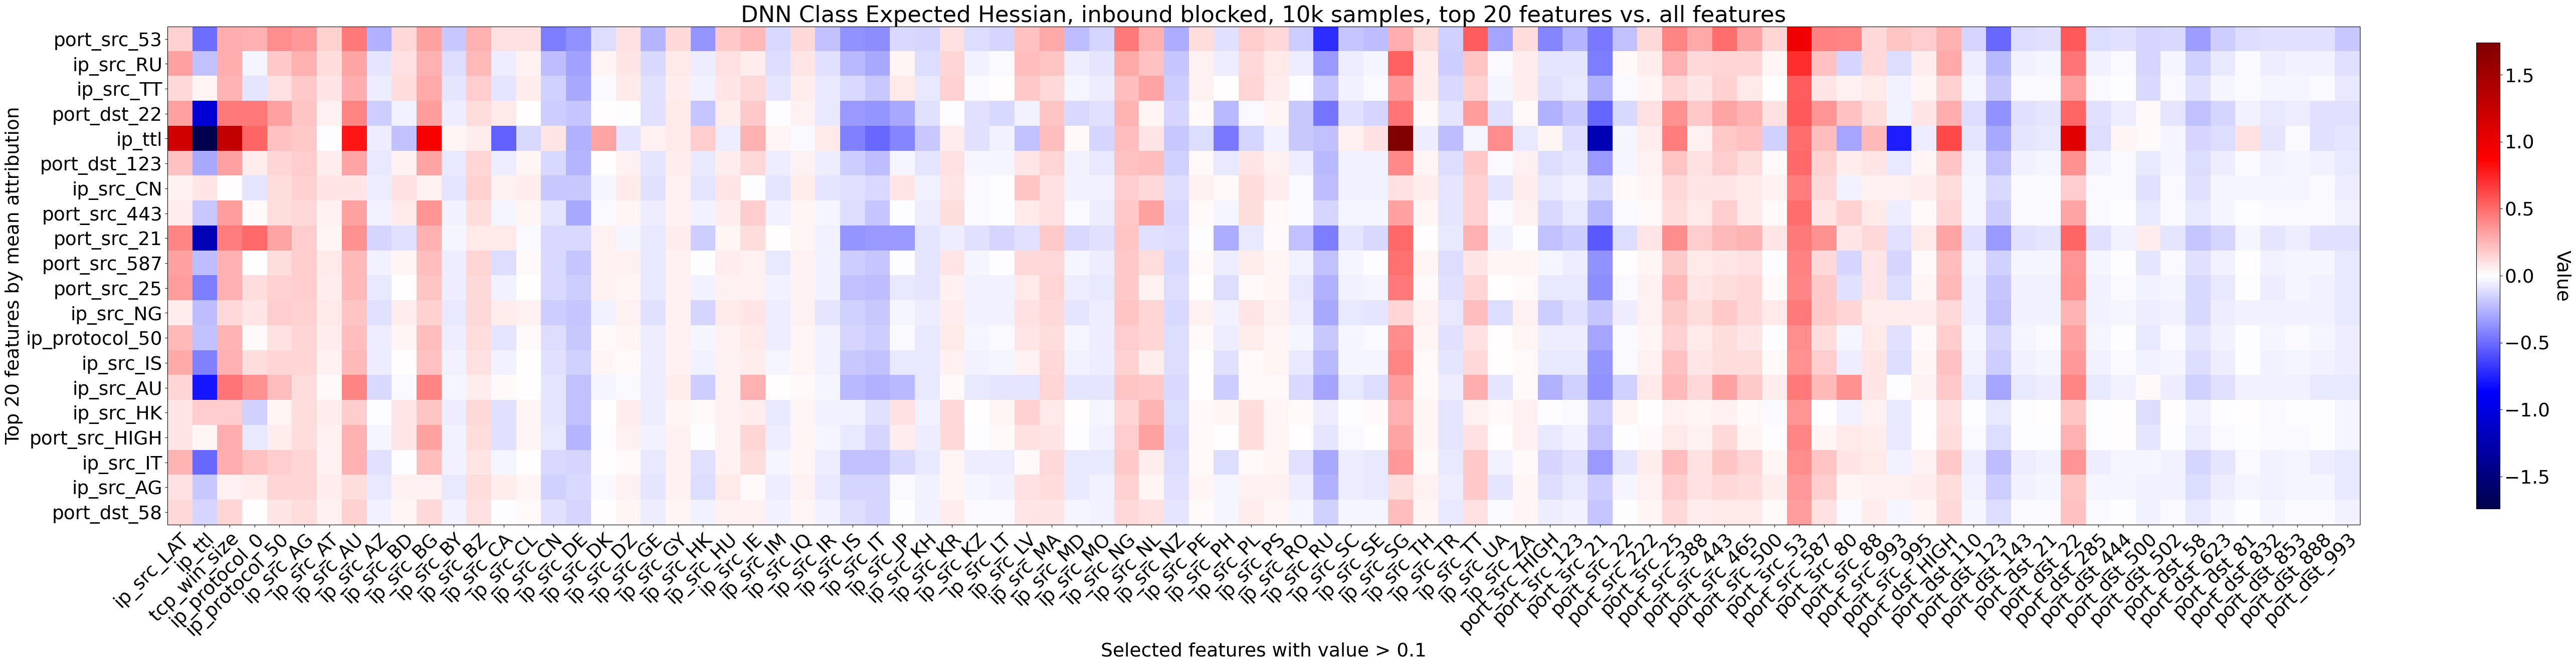

In [177]:
plot = a
x_names = collapse_names
y_names = ynames

fig, ax = plt.subplots(figsize=(52, 52))
matplotlib.rcParams.update({'font.size': 27})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.01)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel('Top 20 features by mean attribution')
plt.xlabel('Selected features with value > 0.1')
'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="w")
'''
ax.set_title("DNN Class Expected Hessian, inbound blocked, 10k samples, top 20 features vs. all features")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

# allowed

In [178]:
HESSIANS_PATH = '/smallwork/alexander.huang/vanilla_hessians/inbound/10000/49595430/allow_vanilla_interactions.npy'
GRADIENTS_PATH = '/smallwork/alexander.huang/saliency_maps/inbound/all/49595428/allow_saliency_maps.npy'
DATA_DIR = '/data/alexander.huang/data/0903_data/test_drop/inbound_x_test.parq'

df = pd.read_parquet(DATA_DIR)
feature_names = df.columns.tolist()

In [179]:
allowed_hessians = np.load(HESSIANS_PATH)
allowed_hessians.shape

(10000, 381, 381)

In [180]:
allowed_gradients = np.load(GRADIENTS_PATH)
allowed_gradients.shape

(3039558, 381)

In [181]:
avg_gradients = np.mean(allowed_gradients, axis=0)
print(avg_gradients.shape)


(381,)


In [182]:
grad_sign = np.sign(avg_gradients)
print(grad_sign)

[ 1.  1.  1. -1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.
 -1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.
  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1.
  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.
 -1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.
 -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.
 -1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.
  1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.
 -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1

In [183]:
avg_hessian = np.mean(allowed_hessians, axis=0)
std_hessian = np.std(allowed_hessians, axis=0)
print(avg_hessian.shape)
print(avg_hessian)

(381, 381)
[[-0.04455945 -0.00307818 -0.0112321  ...  0.00818416  0.00591215
   0.01032875]
 [-0.00307797 -0.00479891  0.01462306 ...  0.0045443   0.00314703
   0.00426177]
 [-0.01123304  0.01462219 -0.02695574 ...  0.00209856  0.0015318
   0.00285146]
 ...
 [ 0.00818394  0.00454411  0.00209842 ... -0.00122682 -0.00089034
  -0.00165436]
 [ 0.00591187  0.00314689  0.00153166 ... -0.00089032 -0.00064572
  -0.00119802]
 [ 0.01032865  0.00426157  0.00285132 ... -0.00165437 -0.00119805
  -0.00218377]]


In [186]:
interaction_matrix = np.zeros((381,381))
num_features = len(avg_gradients)

# feature by row, so lock each row
for i in range(num_features):
    for j in range(num_features):
        interaction_matrix[i,j] = grad_sign[i] *  avg_hessian[i,j]

In [187]:
print(interaction_matrix)

[[-0.04455945 -0.00307818 -0.0112321  ...  0.00818416  0.00591215
   0.01032875]
 [-0.00307797 -0.00479891  0.01462306 ...  0.0045443   0.00314703
   0.00426177]
 [-0.01123304  0.01462219 -0.02695574 ...  0.00209856  0.0015318
   0.00285146]
 ...
 [-0.00818394 -0.00454411 -0.00209842 ...  0.00122682  0.00089034
   0.00165436]
 [-0.00591187 -0.00314689 -0.00153166 ...  0.00089032  0.00064572
   0.00119802]
 [-0.01032865 -0.00426157 -0.00285132 ...  0.00165437  0.00119805
   0.00218377]]


In [188]:
print(feature_names)

['outside_ip_len', 'outside_ip_src_LAT', 'outside_ip_src_LONG', 'outside_ip_ttl', 'outside_tcp_win_size', 'outside_ip_protocol_0', 'outside_ip_protocol_17', 'outside_ip_protocol_47', 'outside_ip_protocol_50', 'outside_ip_protocol_6', 'outside_ip_src_AE', 'outside_ip_src_AG', 'outside_ip_src_AL', 'outside_ip_src_AM', 'outside_ip_src_AO', 'outside_ip_src_AR', 'outside_ip_src_AT', 'outside_ip_src_AU', 'outside_ip_src_AZ', 'outside_ip_src_BD', 'outside_ip_src_BE', 'outside_ip_src_BF', 'outside_ip_src_BG', 'outside_ip_src_BH', 'outside_ip_src_BI', 'outside_ip_src_BR', 'outside_ip_src_BS', 'outside_ip_src_BW', 'outside_ip_src_BY', 'outside_ip_src_BZ', 'outside_ip_src_CA', 'outside_ip_src_CH', 'outside_ip_src_CL', 'outside_ip_src_CM', 'outside_ip_src_CN', 'outside_ip_src_CO', 'outside_ip_src_CR', 'outside_ip_src_CY', 'outside_ip_src_CZ', 'outside_ip_src_DE', 'outside_ip_src_DK', 'outside_ip_src_DO', 'outside_ip_src_DZ', 'outside_ip_src_EC', 'outside_ip_src_EE', 'outside_ip_src_EG', 'outside_i

In [189]:
ipfeatureindex = []
ipfeaturenames = []
for ele in feature_names:
    if ele.startswith('outside_ip_src_'):
        #print(ele)
        name = ele.removeprefix('outside_ip_src_')
        ipfeaturenames.append(name)
        ipfeatureindex.append(feature_names.index(ele))
print(len(ipfeaturenames))
print(len(ipfeatureindex))

143
143


In [190]:
portfeatureindex = []
portfeaturenames = []
for ele in feature_names:
    if ele.startswith('outside_port_src_'):
        name = ele.removeprefix('outside_port_src_')
        #print(ele)
        portfeaturenames.append(name)
        portfeatureindex.append(feature_names.index(ele))
print(len(portfeaturenames))
print(len(portfeatureindex))

21
21


In [191]:
iptoport = np.zeros(shape=(len(portfeatureindex),len(ipfeatureindex)))
a = 0
for i in portfeatureindex:
    b=0
    for j in ipfeatureindex:
        iptoport[a,b] = interaction_matrix[i,j]
        b+=1
    a+=1

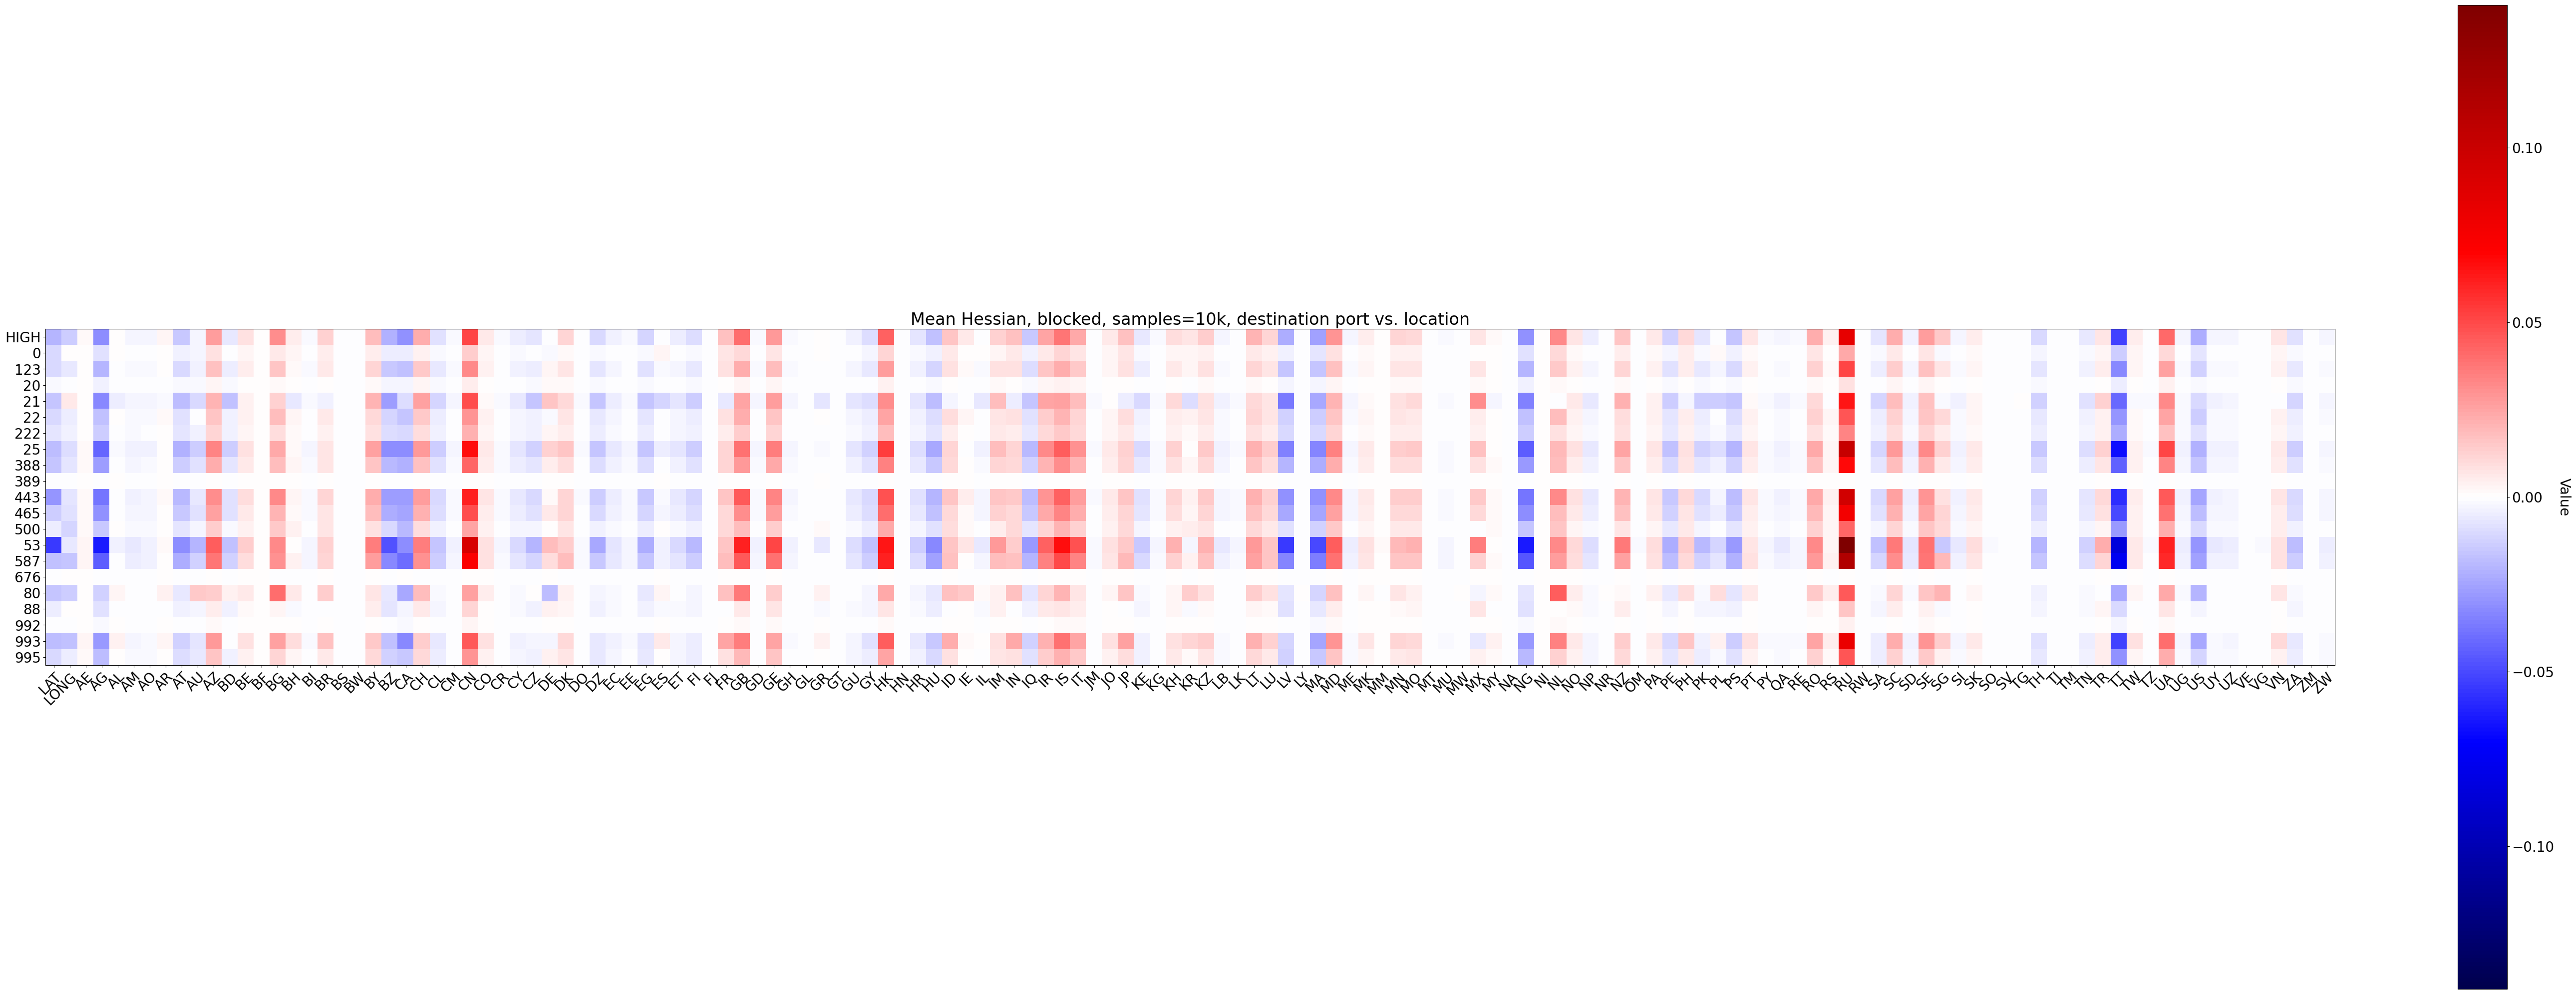

In [194]:
plot = iptoport
x_names = ipfeaturenames
y_names = portfeaturenames

fig, ax = plt.subplots(figsize=(52, 52))
matplotlib.rcParams.update({'font.size': 20})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.02)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="b")
'''

ax.set_title("Mean Hessian, blocked, samples=10k, destination port vs. location")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

In [195]:
short_names = []
for item in feature_names:
    short_names.append(item.removeprefix('outside_'))

In [196]:
# top feature attributions
top10_grads = np.flip(np.sort(np.abs(avg_gradients))[-20:])
avg_gradients.shape

(381,)

In [197]:
print(top10_grads)

[0.05453363 0.05051326 0.03466427 0.03317795 0.03252404 0.03170195
 0.03072813 0.03037908 0.02981444 0.02831363 0.02705569 0.02631445
 0.02540086 0.02535703 0.02532493 0.02458259 0.02316739 0.02219936
 0.02211467 0.02154666]


In [198]:
top10_index = []
for item in top10_grads:
    top10_index.append(np.argwhere(np.abs(avg_gradients) == item).ravel()[0])
#top10_index = np.argwhere(avg_gradients >= np.min(top10_grads, 0)).squeeze()
print(top10_index)

[120, 164, 34, 137, 165, 158, 232, 202, 3, 155, 71, 100, 8, 161, 11, 60, 296, 140, 162, 1]


In [199]:
top10_names = []
for index in top10_index:
    top10_names.append(feature_names[index])
    
for i in range(len(top10_index)):
    idx = top10_index[i]
    print(i+1,'. ', top10_names[i], ': ', avg_gradients[idx], sep='')

1. outside_ip_src_RU: -0.054533627
2. outside_port_src_53: 0.05051326
3. outside_ip_src_CN: -0.03466427
4. outside_ip_src_TT: 0.033177946
5. outside_port_src_587: 0.032524038
6. outside_port_src_25: 0.031701952
7. outside_port_dst_22: 0.030728133
8. outside_port_dst_123: -0.030379076
9. outside_ip_ttl: -0.029814437
10. outside_port_src_21: -0.028313633
11. outside_ip_src_IS: -0.027055694
12. outside_ip_src_NG: 0.026314452
13. outside_ip_protocol_50: 0.025400858
14. outside_port_src_443: 0.025357028
15. outside_ip_src_AG: 0.025324926
16. outside_ip_src_HK: -0.02458259
17. outside_port_dst_58: -0.023167392
18. outside_ip_src_UA: -0.02219936
19. outside_port_src_465: 0.02211467
20. outside_ip_src_LAT: 0.021546658


In [200]:
num_features = len(avg_gradients)

top10_interaction_matrix = np.zeros((len(top10_index),num_features))
a = 0
for i in top10_index:
    for j in range(num_features):
        top10_interaction_matrix[a,j] = grad_sign[i] *  avg_hessian[i,j]
    a+=1

In [201]:
top10_interaction_matrix.shape

(20, 381)

In [202]:
a = 0
xnames = []
ynames = []
for i in top10_index:
    for j in range(num_features):
        print(short_names[i],',\t', short_names[j], '\t:', top10_interaction_matrix[a][j])
    ynames.append(short_names[i])
    a+=1

ip_src_RU ,	 ip_len 	: -0.08488127589225769
ip_src_RU ,	 ip_src_LAT 	: -0.042027659714221954
ip_src_RU ,	 ip_src_LONG 	: -0.01682817004621029
ip_src_RU ,	 ip_ttl 	: 0.09937770664691925
ip_src_RU ,	 tcp_win_size 	: 0.04996605962514877
ip_src_RU ,	 ip_protocol_0 	: -0.06817162781953812
ip_src_RU ,	 ip_protocol_17 	: 0.021626077592372894
ip_src_RU ,	 ip_protocol_47 	: 0.018139680847525597
ip_src_RU ,	 ip_protocol_50 	: -0.08808831870555878
ip_src_RU ,	 ip_protocol_6 	: -0.011295541189610958
ip_src_RU ,	 ip_src_AE 	: 0.0042623914778232574
ip_src_RU ,	 ip_src_AG 	: -0.07672243565320969
ip_src_RU ,	 ip_src_AL 	: -0.0012536346912384033
ip_src_RU ,	 ip_src_AM 	: -0.007439157925546169
ip_src_RU ,	 ip_src_AO 	: -0.005909692961722612
ip_src_RU ,	 ip_src_AR 	: 0.001702614245004952
ip_src_RU ,	 ip_src_AT 	: -0.03783108666539192
ip_src_RU ,	 ip_src_AU 	: -0.026753045618534088
ip_src_RU ,	 ip_src_AZ 	: 0.06356941908597946
ip_src_RU ,	 ip_src_BD 	: -0.0206497460603714
ip_src_RU ,	 ip_src_BE 	: 0.01638

In [203]:
print(len(short_names))
print(len(ynames))

381
20


In [204]:
top10_interaction_matrix.shape

(20, 381)

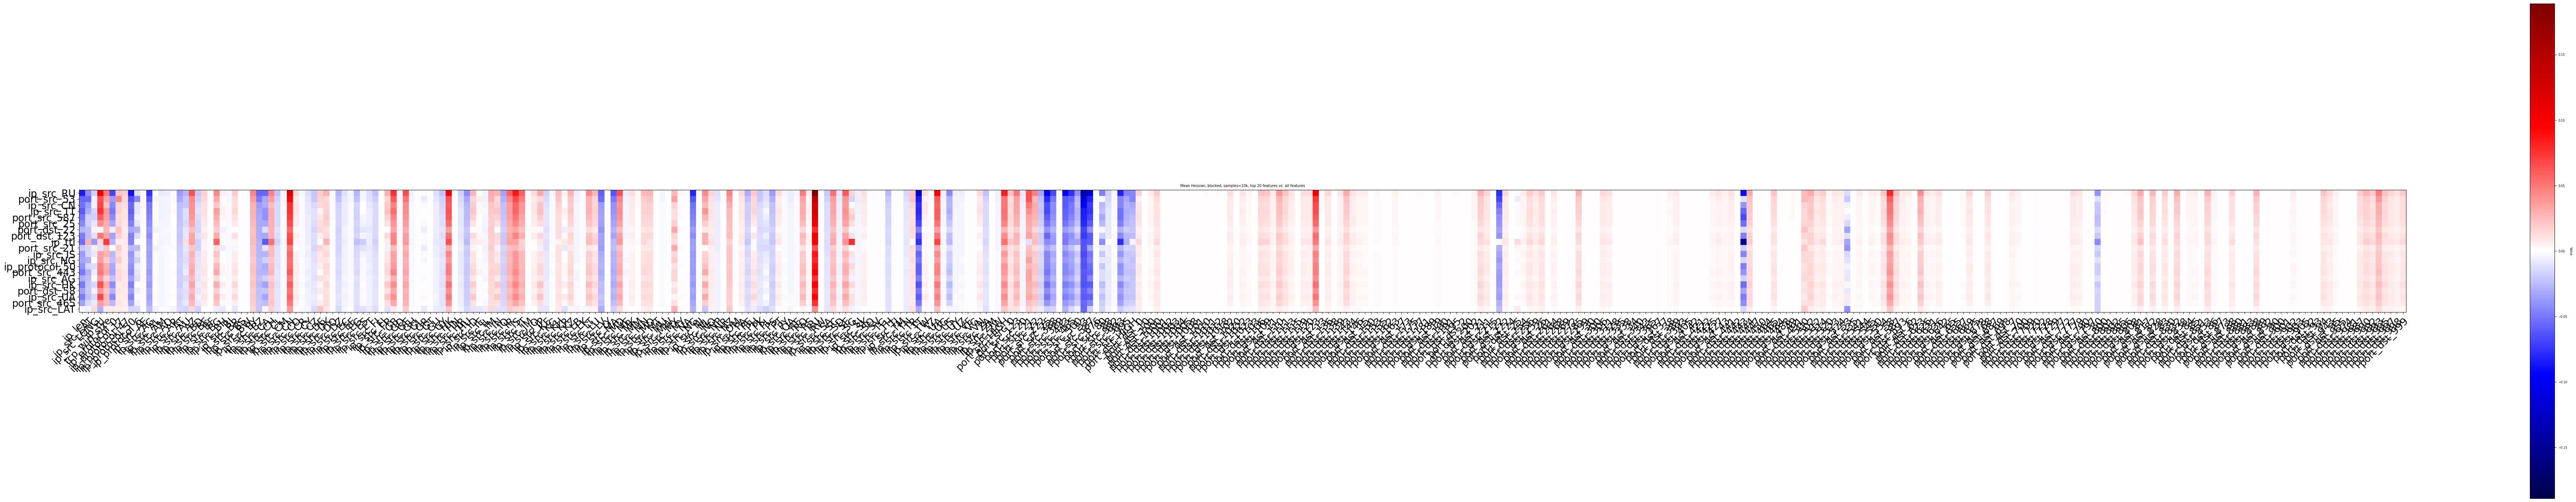

In [205]:
plot = top10_interaction_matrix
x_names = short_names
y_names = ynames

fig, ax = plt.subplots(figsize=(72, 72))
matplotlib.rcParams.update({'font.size': 6})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.01)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="b")
'''

ax.set_title("Mean Hessian, blocked, samples=10k, top 20 features vs. all features")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)

In [206]:
# remove columns
threshold = 0.02
indices = np.where(abs(top10_interaction_matrix[0,:]) < abs(threshold))
print(indices[0])
print(len(indices[0]))
a = np.delete(top10_interaction_matrix, indices, axis=1)
print(a.shape)
collapse_names = short_names.copy()

for index in indices[0]:
    collapse_names.remove(short_names[index])
    
print(len(collapse_names))

[  2   7   9  10  12  13  14  15  20  21  23  24  25  26  27  33  35  36
  37  39  41  43  44  46  47  49  52  54  55  56  57  58  61  62  65  66
  73  74  76  77  79  81  82  86  89  90  91  94  95  96  98  99 101 103
 104 105 107 108 110 112 114 115 116 117 119 121 124 126 127 128 129 130
 131 133 134 135 138 139 141 143 144 145 146 147 149 150 154 160 166 168
 169 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 195 198 199 200 201 203 204 205 206 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 230 231 233
 234 235 236 237 238 240 241 242 243 244 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 274 275 276 278 279 280 281 284 285 286 287 288 289 290 291 292 293 294
 298 299 300 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320 321 322 323 324 325 326 327 328 329 331 332 333 334 335
 336 338 340 341 342 344 345 346 347 349 350 351 35

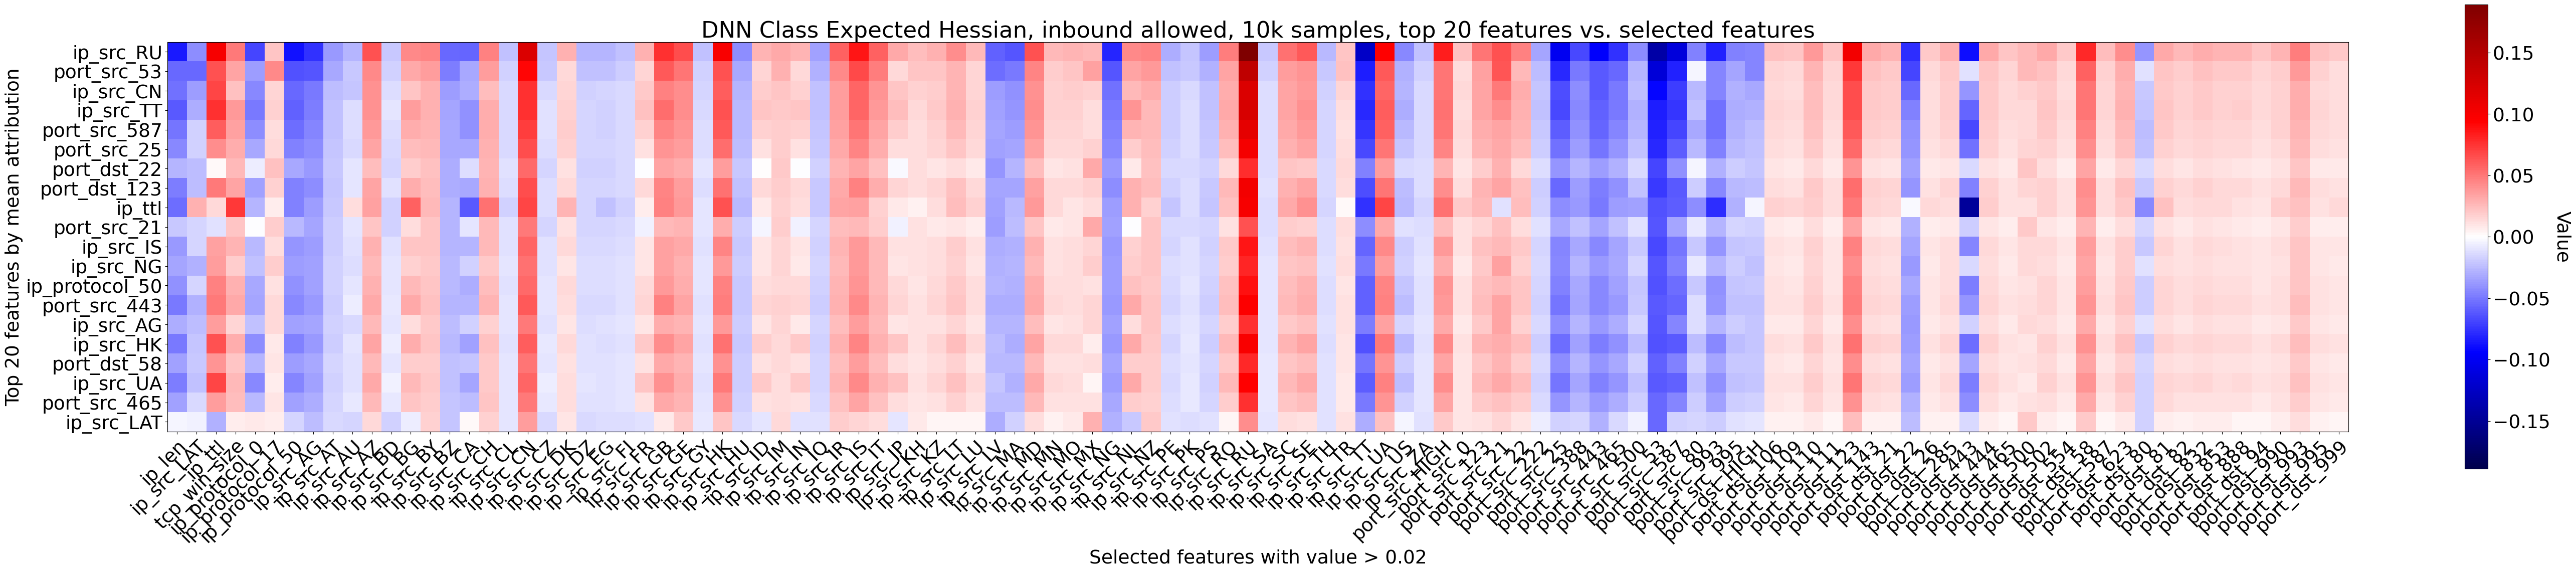

In [208]:
plot = a
x_names = collapse_names
y_names = ynames

fig, ax = plt.subplots(figsize=(52, 52))
matplotlib.rcParams.update({'font.size': 27})

lim = tf.reduce_max(abs(plot))
im = ax.imshow(plot, vmin=-lim, vmax=lim, cmap='seismic')

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.01)
cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x_names)), labels=x_names)
ax.set_yticks(np.arange(len(y_names)), labels=y_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel('Top 20 features by mean attribution')
plt.xlabel('Selected features with value > 0.02')
'''
for i in range(len(y_names)):
    for j in range(len(x_names)):
        text = ax.text(j, i, round(plot[i, j],2),
                        ha="center", va="center", color="w")
'''
ax.set_title("DNN Class Expected Hessian, inbound allowed, 10k samples, top 20 features vs. selected features")
fig.tight_layout()
#plt.savefig('hessian.png', dpi=300)